# Carpet Claim Data Analysis
Investigate the defects in the delamination testing data using one monthe data (Aug 2017) at various intervals

R1: Accumulated Customer sales + claims ... Nov 2017

- #Claims

- $/Claim

- #Sales

- $/Sale

- $Claim /$Sale

R2: Add product info...Dec 2017

- Customer
 - #Sales
 - $/Sale
 

- Claim
 - Product Style
 - Product Size
 - Product Backing
 - Product Color
 - $/claim
 - Claim/Total Sale
 
Product+Roll: Add roll info ... Feb 2018
- Directly obtain trainng data from HANA via Python script ..."claim_product2017.csv"
- Customer
- Product
- Roll
  - F1ROLL
  - F1PROL
  - F1GROL
  - F1DLOT
  'CLAIM_NUM', 'INVENTORY_STYLE_CD', 'INVENTORY_SIZE_CD', 'INVENTORY_BACKING_CD', 'INVENTORY_COLOR_CD', 'DIM_DIVISION_CUSTOMER_GK', 'F1ROLL', 'F1PROL', 'F1GROL', 'F1DLOT', 'CLAIM_STATUS_TYPE_CD', 'CLAIM', 'TOTAL_CLAIM', 'TOTAL_CLAIM_CNT', 'TRX_CNT', 'NET_SALES'

In [1]:
# Load necessary libraries
import numpy as np
import pandas as pd
import os, inspect
import copy
import csv
import pickle
%matplotlib inline 
import pylab
import matplotlib.pylab as plt
import matplotlib.image as img
import scipy.stats as stats
import seaborn as sns
from IPython.core.display import HTML 
from sklearn.preprocessing import scale
from bokeh.io import show, output_file
from bokeh.plotting import figure
#from bokeh.charts import Bar, BoxPlot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from collections import Counter

# Define functions

In [2]:
#define a function to visualize results
def _plot_value_series(self, dt, factor, yName, iplot, varDefect=None):
    #self is data array
    nrow = len(self)
    #Feature
    self_max = np.max(self)
    self_min = np.min(self)
    self_mu = np.mean(self)
    self_std = np.std(self)
    upper_limit = self_mu + factor * self_std;
    lower_limit = self_mu - factor * self_std;
    
    #create a vector
    ts = range(nrow)
 
    #check timepoints
    len_time = len(dt)
    if len_time > nrow or len_time < nrow:
        dt = ts
        
    fig = plt.figure(figsize=(11,4))    
    ax = plt.subplot(111)  
    
     #plt.plot(dt,X,'k-')
    s1 = np.random.rand(*dt.shape) * 80 + 50
    plt.scatter(dt,self, s1, c="k", alpha = 0.8)  
    #plt.plot(dt,self,'k-')
    
    #####horizontal line
    upper_limit_data = np.array([upper_limit for i in range(len(dt))])
    plt.plot(dt, upper_limit_data, 'r--', label='Upper Limit') 

    lower_limit_data = np.array([lower_limit for i in range(len(dt))])
    plt.plot(dt, lower_limit_data, 'g--', label='Lower Limit') 
    
    #ax.axhline(y=upper_limit, xmin=dt[0], xmax = dt[len(dt)-1],color = 'b', label='Upper limit')
    #ax.axhline(y=lower_limit, xmin=dt[0], xmax = dt[len(dt)-1],color='g', label='Lower limit')
    plt.ylabel(yName)
    plt.xlabel('Time')
    
    # retrieving the indices where "sng > max" using np.where    
    upperIndex = []
    upperCnt = 0.0
    lowerIndex = []
    lowerCnt = 0.0
    for index, item in enumerate(self):        
        if item > upper_limit:
            upperCnt += 1.0
            upperIndex.append(index)
            plt.plot(dt[index],item, 'bs') 
        else:
            if item < lower_limit:
                lowerCnt += 1.0
                lowerIndex.append(index)
                plt.plot(dt[index],item, 'ms')           
            
        if varDefect is not None and varDefect[index] > 0:
            s = np.pi * varDefect[index]**2 #np.random.rand(*dt.shape) * 80 + 50
            plt.scatter(dt[index],item,s, c="r", alpha = 0.5)         
            
    # Now add the legend with some customizations.
    legend = ax.legend(loc='best', shadow=True)

    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.0)  # the legend line width
    
    plt.show()
    
    # display the failure data points
    if (iplot == 1) and (upperCnt > 0.0):
        print('Number of above upper limit points = ', upperCnt)
        print('Above upperlimit points:', upperIndex)        
    
    if (iplot == 1) and (lowerCnt > 0.0):
        print('Number of below lowerlimit points = ', lowerCnt)
        print('Below lowerlimit points:', lowerIndex)    

In [3]:
#Visualizing Interrelationships between Attributes - scatter
def _plot_multivariate(self):
    plt.figure(figsize=(14,14))
    pd.plotting.scatter_matrix(self, diagonal="kde") 
    plt.tight_layout()
    plt.show()

In [4]:
#Visualizing Attribute and Label Correlations Using a Heat Map
#calculate correlations between real-valued attributes
def _plot_heatmap(self):
    xcorMat = pd.DataFrame(self.corr())
    #visualize correlations using heatmap
    plt.pcolor(xcorMat)
    plt.show() 

In [5]:
# plot quantile-quantile of data   
def _plot_QQ(self):    
    #plot quantile-quantile of a timeseries
    stats.probplot(self, dist="norm", plot=plt)
    plt.show() 

In [6]:
def _plot_boxplot(self):
    #plot box plot of one variable or matrix
    plt.figure(figsize=(11,11)) 
    plt.boxplot(self, 0, 'rD', 0, 0.75)    
    plt.show()

In [7]:
def _timeseries_plot(self):
    #plot time series of univaraite or multivariable
    plt.figure(figsize=(15,4))
    ax = self.plot()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.show()
    plt.show()

In [8]:
# clean latex type
def _read_tagData(dataModel, tag, thred):    
    dataModel_output = dataModel.loc[lambda dataModel: dataModel[tag] == thred, :]
    #print(dataModel.loc[:,['GFROLL', 'GFLTYP','delamIndex', 'delamMin']], len(dataModel_output.GFROLL))
    return dataModel_output

In [9]:
def _read_upper(dataModel, tag, upperThred):    
    dataModel_output = dataModel.loc[lambda dataModel: dataModel[tag] <= upperThred,:]
    return dataModel_output
        
def _read_lower(dataModel, tag, lowerThred):    
    dataModel_output = dataModel.loc[lambda dataModel: dataModel[tag] >= lowerThred,:]
    return dataModel_output

def _drop_rows(dataModel, tag, thred):
    #drop other GFTYPE
    # thred can be a numerical or string   
    
    dataModel_rem = dataModel[dataModel[tag] != thred]
    return dataModel_rem

In [10]:
def class_info(classes):
    counts = Counter(classes)
    total = sum(list(counts.values()))
    
    cper = []
    for cls in counts.keys():
        print("%6s: % 7d  =  % 5.1f%%" % (cls, counts[cls], counts[cls]/total*100))
        cper.append(counts[cls]/total)
    
    return counts, cper

In [11]:
 def _create_filename(path, fname, prefix ='', affix = '.csv'):
        # create new file name
                    
        output_name = prefix + fname + affix        
        foutput_name = os.path.join(path, '', output_name)
              
        return foutput_name

In [12]:
def _plot_classbar(x_claims, y_pos):
    fig, ax = plt.subplots()

    ax.bar(y_pos, x_claims, align='center', color=['red', 'blue'])
   
    pclaim = [y/sum(x_claims) for y in x_claims]
    for i, (v, p) in enumerate(zip(x_claims, pclaim)):
        ax.text(i, v-5, str(v), color='black', fontweight='bold')

    ax.set_xticks(y_pos, objects)
    plt.ylabel('#Claims')
    plt.title('Claims Type')

    plt.show()

In [13]:
# models
class label_encoder(object):
    def fit_pd(self,df,cols=[]):
        '''
        fit all columns in the df or specific list. 
        generate a dict:
        {feature1:{label1:1,label2:2}, feature2:{label1:1,label2:2}...}
        '''
        if len(cols) == 0:
            cols = df.columns
        self.class_index = {}
        for f in cols:
            uf = df[f].unique()
            self.class_index[f] = {}
            index = 1
            for item in uf:
                self.class_index[f][item] = index
                index += 1
    
    def fit_transform_pd(self,df,cols=[]):
        '''
        fit all columns in the df or specific list and return an update dataframe.
        '''
        if len(cols) == 0:
            cols = df.columns
        newdf = copy.deepcopy(df)
        self.class_index = {}
        for f in cols:
            uf = df[f].unique()
            self.class_index[f] = {}
            index = 1
            for item in uf:
                self.class_index[f][item] = index
                index += 1
                
            newdf[f] = df[f].apply(lambda d: self.update_label(f,d))
        return newdf
    
    def transform_pd(self,df,cols=[]):
        '''
        transform all columns in the df or specific list from lable to index, return an update dataframe.
        '''
        newdf = copy.deepcopy(df)
        if len(cols) == 0:
            cols = df.columns
        for f in cols:
            if f in self.class_index:
                newdf[f] = df[f].apply(lambda d: self.update_label(f,d))
        return newdf
                
    def update_label(self,f,x):
        '''
        update the label to index, if not found in the dict, add and update the dict.
        '''
        try:
            return self.class_index[f][x]
        except:
            self.class_index[f][x] = max(self.class_index[f].values())+1
            return self.class_index[f][x]

In [14]:
def _convert_float(data, tag):
    df = data[tag]
    float_list = [float(x) for x in df]
    #float_list = pd.DataFrame(float_list, index = data.index, columns = data.columns)
    data[tag]=float_list
    return data

In [15]:
def sort_class(dataModel, tag):
    count, cper = class_info(dataModel[tag])
    size_df = pd.DataFrame(data = list(count.values()), index = list(count.keys()), columns = [tag])

    total = sum(list(count.values()))
    size_sorted = sorted(size_df[tag], reverse=True)
    size_sorted = pd.DataFrame(size_sorted, index = size_df.index, columns = [tag])
    size_sorted['percent'] = size_sorted[tag]/total
    
    return size_sorted

In [16]:
# Data to plot
def _plot_datapie(data, tag):
    
    labels = list(data.index)
    sizes = list(data[tag].values)
    nlabel = len(labels)
    
    colors = ['green', 'red', 'lightcoral', 'lightskyblue', 'blue', 'gold','lightgreen', 
              'plum', 'magenta', 'black', 'pink', 'grey', 'cyan', 'yellow','silver']
    explode = (0.1, 0, 0, 0, 0, 0, 0,0,0,0,0,0,0,0,0)  # explode 1st slice
 
    # Plot
    plt.pie(sizes, explode=explode[0:nlabel], labels=labels, colors=colors[0:nlabel],
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.show()

In [17]:
# Data to plot
def _plot_classpie(data):
    labels = list(data.keys())
    sizes = list(data.values())
    nlabel = len(labels)
        
    colors = ['green', 'red', 'lightcoral', 'lightskyblue', 'blue', 'gold', 'lightgreen', 
              'plum', 'magenta', 'black', 'pink', 'grey', 'cyan', 'yellow','silver']
    explode = (0.1, 0, 0, 0, 0, 0, 0,0,0,0,0,0,0,0,0)  # explode 1st slice
 
    # Plot
    plt.pie(sizes, explode=explode[0:nlabel], labels=labels, colors=colors[0:nlabel],
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.show()

In [18]:
def group_value(data_sorted, tag, thred):
    # data sorted = data frame
    #thred = percentage
    data_nq = data_sorted.loc[lambda data_sorted: data_sorted['percent'] >= thred,:]
    nq = data_nq.shape[0]
    total = data_sorted[tag].sum()
    data_nq5  = data_sorted.iloc[0:nq,0].sum()

    # add a row 'others'
    data_nq.loc['others'] = [total-data_nq5, (total-data_nq5)/total]
    data_nq = pd.DataFrame(data_nq)
    return data_nq

In [19]:
# set working directory
#curPath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
#parentDir = os.path.split(curPath)[0];
parentDir = 'C:/Users/E154709/Desktop/Mohawk/Claims'
os.chdir(parentDir)

outputPath = parentDir + '/Output/'
if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    
codePath = parentDir + '/Code/'
if not os.path.exists(codePath):
    os.mkdir(codePath)
    
dataPath = parentDir + '/Data/'
if not os.path.exists(dataPath):
    os.mkdir(dataPath)
    
modelPath = parentDir + '/Model/'
if not os.path.exists(modelPath):
    os.mkdir(modelPath)

In [20]:
#create data file
    
fname = 'rawData_con'
frawData = _create_filename(dataPath,fname)
print(frawData)

fname = 'processedData_con'
fprocData = _create_filename(dataPath,fname)
print(fprocData)

fname = 'modelData2018'
fmodelData = _create_filename(dataPath,fname)
print(fmodelData)

fname = 'SmartClaim'
prefix = 'encoder_'
affix = '.pkl'
fmodelPara = _create_filename(modelPath,fname, prefix, affix)
print(fmodelPara)

C:/Users/E154709/Desktop/Mohawk/Claims/Data/rawData_con.csv
C:/Users/E154709/Desktop/Mohawk/Claims/Data/processedData_con.csv
C:/Users/E154709/Desktop/Mohawk/Claims/Data/modelData2018.csv
C:/Users/E154709/Desktop/Mohawk/Claims/Model/encoder_SmartClaim.pkl


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc("font",size=14)
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pyodbc 

In [22]:
# Build the connection to HANA
import pyhdb
conn = pyhdb.connect(
    host="cchgpasdb2",
    port=32553,
    user="MART_RDR_2",
    password="Re@d3r13"
)

In [23]:
# Check the connection
cursor = conn.cursor()
cursor.execute("select current_date from dummy")
for row in cursor.fetchall():
    print(row)

(datetime.date(2018, 3, 15),)


# Read Claim Data by SQL from HANA connection

Run this section only if we have not preprocessed the raw data. Otherwise, directly go to the section of claim data processing
Historical pattern of customer (Claims + Sales), Product Attributes (Color, Style, Backing, & Size), and Roll historical claims
- Customer
- Sale
- Product
- Roll 

In [25]:
conn = pyhdb.connect(
    host="cchgpasdb2",
    port=32553,
    user="MART_RDR_2",
    password="Re@d3r13"
)

df = pd.read_sql_query("""select 
	Claim.CLAIM_NUM
	,Claim.INVENTORY_STYLE_CD 
	,Claim.INVENTORY_SIZE_CD 
	,Claim.INVENTORY_BACKING_CD 
	,Claim.INVENTORY_COLOR_CD 
	,Claim.DIM_DIVISION_CUSTOMER_GK 
	,Claim.F1ROLL
	,Claim.F1PROL
	,Claim.F1GROL
	,Claim.F1DLOT
	,Claim.Claim_Status_Type_Cd
	,sum(claim) as Claim 
	,sum(Total_Claim) as Total_Claim 
	,sum(Claim_Cnt) as Total_Claim_Cnt 
	,sum(Trx_cnt) as Trx_cnt 
	,sum(Net_Sales) as Net_Sales  
	from  
		(  
			select 
					CLAIM_NUM
					,INVENTORY_STYLE_CD 
					,INVENTORY_SIZE_CD 
					,INVENTORY_BACKING_CD 
					,INVENTORY_COLOR_CD 
					,DIM_DIVISION_CUSTOMER_GK 
					,F1ROLL
					,F1PROL
					,F1GROL
					,F1DLOT
					,Claim_Status_Type_Cd
					,sum(TOTAL_CLAIMS_DOLLAR_AMT) as Claim 
			from 
					"MHK_EDW_MART"."FACT_CUSTOMER_CLAIMS" A 
					,"MHK_EDW_MART"."DIM_CLAIM_STATUS" B 
					,"MHK_EDW_MART"."DIM_CLAIM_REASON" C 
					,"MHK_EDW_MART"."DIM_FINISHED_PRODUCT_MFG_TYPE1" D 
					,"MHK_EDW_MART"."FIP010"  E
			where 
					A.DIM_CLAIM_STATUS_PK=B.DIM_CLAIM_STATUS_PK 
					and A.DIM_CLAIM_REASON_PK = C.DIM_CLAIM_REASON_PK 
					and A.DIM_FINISHED_PRODUCT_MFG_GK = D.DIM_FINISHED_PRODUCT_MFG_GK 
					and QUALITY_RELATED_CD = 'Y' and A.DIM_FINISHED_PRODUCT_MFG_GK >0 
					and A.FINISHED_ROLL_NUM = E.F1ROLL
					and Claim_Status_Type_Cd in ('48','49','50','51','30','35','36','34')
					and A.CLAIM_STATUS_DATE_PK >20170101
			group by 
					CLAIM_NUM
					,INVENTORY_STYLE_CD 
					,INVENTORY_SIZE_CD 
					,INVENTORY_BACKING_CD 
					,INVENTORY_COLOR_CD 
					,DIM_DIVISION_CUSTOMER_GK 
					,F1ROLL
					,F1PROL
					,F1GROL
					,F1DLOT
					,Claim_Status_Type_Cd
			having 
					sum(TOTAL_CLAIMS_DOLLAR_AMT) >0 
		) Claim ,
		( 
				select 
						INVENTORY_STYLE_CD 
						,INVENTORY_SIZE_CD 
						,INVENTORY_BACKING_CD 
						,INVENTORY_COLOR_CD 
						,DIM_DIVISION_CUSTOMER_GK 
						,sum(TOTAL_CLAIMS_DOLLAR_AMT) as Total_Claim 
						,count(distinct CLAIM_NUM) as Claim_Cnt 
				from 
						"MHK_EDW_MART"."FACT_CUSTOMER_CLAIMS" A 
						,"MHK_EDW_MART"."DIM_CLAIM_STATUS" B 
						,"MHK_EDW_MART"."DIM_CLAIM_REASON" C 
						,"MHK_EDW_MART"."DIM_FINISHED_PRODUCT_MFG_TYPE1" D 
						,"MHK_EDW_MART"."DIM_BUSINESS_UNIT_DATE" E 
						,"MHK_EDW_MART"."FIP010"  F
						
				where 
						A.DIM_CLAIM_STATUS_PK=B.DIM_CLAIM_STATUS_PK 
						and A.DIM_CLAIM_REASON_PK = C.DIM_CLAIM_REASON_PK 
						and A.DIM_FINISHED_PRODUCT_MFG_GK = D.DIM_FINISHED_PRODUCT_MFG_GK 
						and A.FINISHED_ROLL_NUM = F.F1ROLL
						and QUALITY_RELATED_CD = 'Y' 
						and Claim_Status_Type_Cd in ('48','49','50','51','30','35','36','34') 
						and A.CLAIM_STATUS_DATE_PK =E.DIM_DATE_PK 
						and BUSINESS_UNIT_CD='MF' 
						and FIRST_OF_FISCAL_YEAR_DT between '2016-01-01' and Current_date 
						and A.DIM_FINISHED_PRODUCT_MFG_GK >0 
						
				group by 
					INVENTORY_STYLE_CD 
					,INVENTORY_SIZE_CD 
					,INVENTORY_BACKING_CD 
					,INVENTORY_COLOR_CD 
					,DIM_DIVISION_CUSTOMER_GK
				
				having sum(TOTAL_CLAIMS_DOLLAR_AMT) >0  )HClaim , 
				( 
						select 
								INVENTORY_STYLE_CD 
								,INVENTORY_SIZE_CD 
								,INVENTORY_BACKING_CD 
								,INVENTORY_COLOR_CD 
								,SOLD_TO_CUSTOMER_GK 
								,Count(distinct to_char(SOLD_TO_CUSTOMER_GK) || to_char(DOCUMENT_NUM)) as Trx_cnt 
								,sum(Net_Sales_amt) as Net_Sales 
					  from "MHK_EDW_MART"."FACT_CAMS_GL_SALES_INTERFACE" A 
					  		,"MHK_EDW_MART"."DIM_FINISHED_PRODUCT_MFG_TYPE1" B 
					  		,"MHK_EDW_MART"."DIM_BUSINESS_UNIT_DATE" C  
					  where 
					  		A.ENTRY_DATE_PK =C.DIM_DATE_PK 
					  		and C.BUSINESS_UNIT_CD='MF' 
					  		and FIRST_OF_FISCAL_YEAR_DT 
					  		between '2016-01-01' and Current_date 
					  		and A.FINISHED_PRODUCT_MFG_GK = B.DIM_FINISHED_PRODUCT_MFG_GK 
					  group by 
					  		INVENTORY_STYLE_CD 
					  		,INVENTORY_SIZE_CD 
					  		,INVENTORY_BACKING_CD 
					  		,INVENTORY_COLOR_CD 
					  		,SOLD_TO_CUSTOMER_GK 
					  having sum(Net_Sales_amt)>0 )HSales  
					  where 
					  		Claim.INVENTORY_STYLE_CD = HClaim.INVENTORY_STYLE_CD 
					  		and Claim.INVENTORY_SIZE_CD = HClaim.INVENTORY_SIZE_CD 
					  		and Claim.INVENTORY_BACKING_CD = HClaim.INVENTORY_BACKING_CD 
					  		and Claim.INVENTORY_COLOR_CD = HClaim.INVENTORY_COLOR_CD 
					  		and Claim.DIM_DIVISION_CUSTOMER_GK = HClaim.DIM_DIVISION_CUSTOMER_GK
					  		and	Claim.INVENTORY_STYLE_CD = HSales.INVENTORY_STYLE_CD 
					  		and Claim.INVENTORY_SIZE_CD = HSales.INVENTORY_SIZE_CD 
					  		and Claim.INVENTORY_BACKING_CD = HSales.INVENTORY_BACKING_CD 
					  		and Claim.INVENTORY_COLOR_CD = HSales.INVENTORY_COLOR_CD 
					  		and Claim.DIM_DIVISION_CUSTOMER_GK = HSales.SOLD_TO_CUSTOMER_GK 
					  		 
					 group by 
					 		Claim.CLAIM_NUM
					 		,Claim.INVENTORY_STYLE_CD 
					 		,Claim.INVENTORY_SIZE_CD 
					 		,Claim.INVENTORY_BACKING_CD 
					 		,Claim.INVENTORY_COLOR_CD 
					 		,Claim.DIM_DIVISION_CUSTOMER_GK
					 		,Claim.F1ROLL
							,Claim.F1PROL
							,Claim.F1GROL
							,Claim.F1DLOT
							,Claim.Claim_Status_Type_Cd;
							
						
""",conn)
conn.close()
#df.head(10)
print(df.shape)
print(list(df.columns))
print(df.head())
df.to_csv('claim_product2017.csv')

OperationalError: Lost connection to HANA server (ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [28]:
print(df.shape)

(31692, 16)


In [27]:
print(df[df.loc(CLAIM_NUM='7001282',:)])

SyntaxError: invalid syntax (<ipython-input-27-3edacd5d4684>, line 1)

In [29]:
with open(frawData, 'w') as csvfile:
    df.to_csv(csvfile)

In [ ]:
#read the historical file
with open(frawData, 'r') as csvfile:
    df = pd.read_csv(csvfile)

In [30]:
tags = list(df.columns.values)
print(tags)

['CLAIM_NUM', 'INVENTORY_STYLE_CD', 'INVENTORY_SIZE_CD', 'INVENTORY_BACKING_CD', 'INVENTORY_COLOR_CD', 'DIM_DIVISION_CUSTOMER_GK', 'F1ROLL', 'F1PROL', 'F1GROL', 'F1DLOT', 'CLAIM_STATUS_TYPE_CD', 'CLAIM', 'TOTAL_CLAIM', 'TOTAL_CLAIM_CNT', 'TRX_CNT', 'NET_SALES']


In [31]:
tmpClaim, ptClaim = class_info(df.INVENTORY_STYLE_CD)

 27611:      75  =    0.2%
 27898:      47  =    0.1%
 64017:      19  =    0.1%
 28274:      28  =    0.1%
 27861:     123  =    0.4%
 25760:      26  =    0.1%
   P51:       4  =    0.0%
 28072:     152  =    0.5%
  PSC1:     735  =    2.3%
 28074:     213  =    0.7%
 27949:      43  =    0.1%
 27620:     128  =    0.4%
   P57:      64  =    0.2%
   P81:      90  =    0.3%
   P61:     110  =    0.3%
 28155:      20  =    0.1%
 27952:     165  =    0.5%
 26594:     122  =    0.4%
 28071:      37  =    0.1%
 28031:      15  =    0.0%
 11322:       2  =    0.0%
 28017:      91  =    0.3%
   P83:      18  =    0.1%
 28146:      45  =    0.1%
 28145:     204  =    0.6%
 25220:      38  =    0.1%
 27732:     230  =    0.7%
   C87:     247  =    0.8%
   P77:       4  =    0.0%
 89252:       5  =    0.0%
 25110:      45  =    0.1%
 27892:      89  =    0.3%
 28285:       3  =    0.0%
  KX27:      31  =    0.1%
 27475:     320  =    1.0%
 27660:     141  =    0.4%
 80487:      35  =    0.1%
 

In [32]:
type_unique = set(df.CLAIM_NUM)
uniqueCnt = len(type_unique)
print(uniqueCnt) 

22401


In [33]:
tmpClaim, ptClaim = class_info(df.INVENTORY_SIZE_CD)

  1200:   27713  =   87.4%
  1302:      79  =    0.2%
  0600:    2777  =    8.8%
  1500:    1037  =    3.3%
  0205:       1  =    0.0%
  0206:       5  =    0.0%
  1301:       9  =    0.0%
  0300:       1  =    0.0%
  1300:       9  =    0.0%
  1208:       3  =    0.0%
  0411:      11  =    0.0%
  1306:      36  =    0.1%
  1106:       3  =    0.0%
  1000:       8  =    0.0%


In [34]:
tmpClaim, ptClaim = class_info(df.INVENTORY_COLOR_CD)

   747:     277  =    0.9%
 81289:       1  =    0.0%
  7749:       1  =    0.0%
   720:      56  =    0.2%
   752:      98  =    0.3%
   686:      50  =    0.2%
    12:     240  =    0.8%
   718:     582  =    1.8%
 SMART:     853  =    2.7%
   859:     441  =    1.4%
   728:     514  =    1.6%
   833:      82  =    0.3%
   716:    1118  =    3.5%
   738:     317  =    1.0%
   729:     264  =    0.8%
   727:     523  =    1.7%
   858:     446  =    1.4%
   758:     347  =    1.1%
 18810:       1  =    0.0%
   939:     358  =    1.1%
   725:     322  =    1.0%
    38:     117  =    0.4%
   733:      92  =    0.3%
   732:     410  =    1.3%
   717:     642  =    2.0%
   989:     374  =    1.2%
   999:      89  =    0.3%
   739:     286  =    0.9%
 J8133:       5  =    0.0%
   724:     146  =    0.5%
   852:     262  =    0.8%
   862:     401  =    1.3%
   929:     312  =    1.0%
    27:      31  =    0.1%
   749:     159  =    0.5%
   726:     196  =    0.6%
   983:      28  =    0.1%
 

In [215]:
tmpClaim, ptClaim = class_info(df.INVENTORY_BACKING_CD)

     A:   14316  =   47.5%
    PB:    2643  =    8.8%
     V:     420  =    1.4%
    C1:     500  =    1.7%
     W:     364  =    1.2%
    H5:    2188  =    7.3%
    H4:    8625  =   28.6%
    UU:     448  =    1.5%
     I:       1  =    0.0%
     T:     225  =    0.7%
    NI:      20  =    0.1%
    PZ:      37  =    0.1%
    MG:      58  =    0.2%
    WA:       3  =    0.0%
    BF:      50  =    0.2%
    UB:      36  =    0.1%
    EF:     101  =    0.3%
     J:       1  =    0.0%
    CC:       3  =    0.0%
    DA:       8  =    0.0%
    ED:       2  =    0.0%
    L4:      18  =    0.1%
    D5:      58  =    0.2%
    K2:       1  =    0.0%
     K:       2  =    0.0%
    CB:       1  =    0.0%


# Customer data cleaning and group

In [216]:
#saleNumber = customerData.pivot_table(index='PRIMARY_CUSTOMER_GK', values='SLS', aggfunc=len)
df_sale = df.rename(columns={'TOTAL_CLAIM_CNT': 'numClaims', 'TRX_CNT': 'numSales', 
                                  'TOTAL_CLAIM':'dollarClaims', 'NET_SALES':'dollarSales'})
print(df_sale.head(20), df_sale.shape)

    CLAIM_NUM INVENTORY_STYLE_CD INVENTORY_SIZE_CD INVENTORY_BACKING_CD  \
0     7059763              27475              1200                    A   
1     7001282              28215              1200                    A   
2     7001282              28215              1200                    A   
3     7060428              27973              1200                    A   
4     7028073              28071              1200                    A   
5     7006428              28071              1200                    A   
6     7028063              28071              1200                    A   
7     7060054              28071              1200                    A   
8     6978003              27469              1200                    A   
9     6973372              27469              1200                    A   
10    6980908              27469              1200                    A   
11    6985602              27469              1200                    A   
12    6996736            

In [217]:
tagList = ['numClaims', 'numSales','dollarClaims', 'dollarSales']
modelData = df_sale
for item in tagList:
    modelData = _convert_float(modelData, item)
        
modelData['dollarPerClaim'] = modelData['dollarClaims']/modelData['numClaims']
modelData['dollarPerSale'] = modelData['dollarSales']/modelData['numSales']
modelData['claimRatio'] = modelData['dollarClaims']/modelData['dollarSales']
        
print(modelData.head(4), modelData.shape)
        
# import input tags
#modelData_inf = _replace_inf(modelData)
#X = modelData_inf[INPUT_TAGS]

   CLAIM_NUM INVENTORY_STYLE_CD INVENTORY_SIZE_CD INVENTORY_BACKING_CD  \
0    7059763              27475              1200                    A   
1    7001282              28215              1200                    A   
2    7001282              28215              1200                    A   
3    7060428              27973              1200                    A   

  INVENTORY_COLOR_CD  DIM_DIVISION_CUSTOMER_GK    F1ROLL    F1PROL   F1GROL  \
0                749                    295061  00156844            4303086   
1                728                    228961  06157892  05616699  4835362   
2                728                    228961  06157892  05616699  4835362   
3                858                    337971  07991120            5048554   

    F1DLOT CLAIM_STATUS_TYPE_CD   CLAIM  dollarClaims  numClaims  numSales  \
0  K35101$                   30  743.85        743.85        1.0      89.0   
1  K53885$                   51  504.10        671.66        1.0    2873.0   

# Claim Data Cleaning and Group

In [218]:
#define the list of input tags
INPUT_TAGS = ['numClaims',
              'numSales',
              'dollarPerClaim',
              'dollarPerSale',
              'claimRatio',
              'INVENTORY_STYLE_CD',
              'INVENTORY_SIZE_CD',
              'INVENTORY_BACKING_CD',
              'INVENTORY_COLOR_CD'
              ]

In [219]:
print(modelData.head(2), modelData.shape)

   CLAIM_NUM INVENTORY_STYLE_CD INVENTORY_SIZE_CD INVENTORY_BACKING_CD  \
0    7059763              27475              1200                    A   
1    7001282              28215              1200                    A   

  INVENTORY_COLOR_CD  DIM_DIVISION_CUSTOMER_GK    F1ROLL    F1PROL   F1GROL  \
0                749                    295061  00156844            4303086   
1                728                    228961  06157892  05616699  4835362   

    F1DLOT CLAIM_STATUS_TYPE_CD   CLAIM  dollarClaims  numClaims  numSales  \
0  K35101$                   30  743.85        743.85        1.0      89.0   
1  K53885$                   51  504.10        671.66        1.0    2873.0   

   dollarSales  dollarPerClaim  dollarPerSale  claimRatio  
0     78389.06          743.85     880.775955    0.009489  
1   1875512.47          671.66     652.806290    0.000358   (30129, 19)


In [220]:
type_unique = set(modelData.CLAIM_STATUS_TYPE_CD)
uniqueCnt = len(type_unique)
print(uniqueCnt, type_unique) 

8 {'49', '51', '48', '30', '35', '36', '50', '34'}


    30:    7439  =   24.7%
    51:    4570  =   15.2%
    50:   16757  =   55.6%
    36:     414  =    1.4%
    34:     724  =    2.4%
    35:      70  =    0.2%
    49:      53  =    0.2%
    48:     102  =    0.3%
Counter({'50': 16757, '30': 7439, '51': 4570, '34': 724, '36': 414, '48': 102, '35': 70, '49': 53}) [0.2469049752729928, 0.15168110458362374, 0.5561751136778519, 0.013740914069501144, 0.02403000431477978, 0.002323342958611305, 0.0017591025258057022, 0.0033854425968336153]


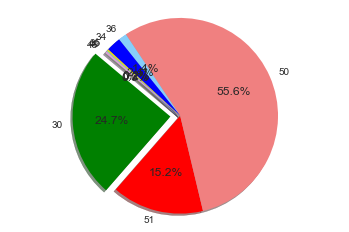

In [224]:
qcount, qper = class_info(modelData.CLAIM_STATUS_TYPE_CD)
print(qcount, qper)
_plot_classpie(qcount)

In [225]:
tag = 'CLAIM_STATUS_TYPE_CD'
sort_type = sort_class(modelData, tag)
print(sort_type)
thred = 0.02
data_nq = group_value(sort_type, tag, thred)
_plot_datapie(data_nq, tag)
data_nq

    30:    7439  =   24.7%
    51:    4570  =   15.2%
    50:   16757  =   55.6%
    36:     414  =    1.4%
    34:     724  =    2.4%
    35:      70  =    0.2%
    49:      53  =    0.2%
    48:     102  =    0.3%
    CLAIM_STATUS_TYPE_CD   percent
30                 16757  0.556175
51                  7439  0.246905
50                  4570  0.151681
36                   724  0.024030
34                   414  0.013741
35                   102  0.003385
49                    70  0.002323
48                    53  0.001759


C:\anaconda35\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


CLAIM_STATUS_TYPE_CD   percent
30                   16757.0  0.556175
51                    7439.0  0.246905
50                    4570.0  0.151681
36                     724.0  0.024030
others                 639.0  0.021209

In [226]:
# digitalize claim_status data into 1 or 0
# Paid = 1
modelData.loc[:,tag] = modelData.loc[:,tag].replace(['48', '49', '50','51'], '1')
# Declined = 0
modelData.loc[:,tag] = modelData.loc[:,tag].replace(['30', '34', '35', '36'], '0')
class_info(modelData[tag])

     0:    8647  =   28.7%
     1:   21482  =   71.3%


(Counter({'0': 8647, '1': 21482}), [0.286999236615885, 0.713000763384115])

     0:    8647  =   28.7%
     1:   21482  =   71.3%
Counter({'1': 21482, '0': 8647}) [0.286999236615885, 0.713000763384115]


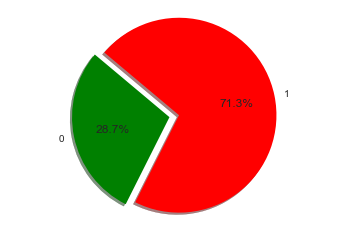

In [227]:
qcount, qper = class_info(modelData[tag])
print(qcount, qper)
_plot_classpie(qcount)

In [228]:
def _drop_rows(dataModel, tag, thred):    
    # thred can be a numerical or string    
    dataModel_rem = dataModel[dataModel[tag] != thred]
    #print(dataModel_rem.shape)     
    return dataModel_rem

In [229]:
objects = qcount.keys()
y_pos = np.arange(len(objects))
x_claims = list(qcount.values())[::-1]
print(x_claims, y_pos, objects)   
_plot_classbar(x_claims, y_pos)

[21482, 8647] [0 1] dict_keys(['0', '1'])


In [230]:
print(modelData.shape, modelData.head())

(30129, 19)    CLAIM_NUM INVENTORY_STYLE_CD INVENTORY_SIZE_CD INVENTORY_BACKING_CD  \
0    7059763              27475              1200                    A   
1    7001282              28215              1200                    A   
2    7001282              28215              1200                    A   
3    7060428              27973              1200                    A   
4    7028073              28071              1200                    A   

  INVENTORY_COLOR_CD  DIM_DIVISION_CUSTOMER_GK    F1ROLL    F1PROL   F1GROL  \
0                749                    295061  00156844            4303086   
1                728                    228961  06157892  05616699  4835362   
2                728                    228961  06157892  05616699  4835362   
3                858                    337971  07991120            5048554   
4                888                    333541  06917531            4882770   

     F1DLOT CLAIM_STATUS_TYPE_CD   CLAIM  dollarClaims  numClaims  n

In [231]:
tag = 'INVENTORY_BACKING_CD'
count, cper = class_info(modelData[tag])
tag_unique = set(modelData[tag])
uniqueCnt = len(tag_unique)
print(uniqueCnt)

     A:   14316  =   47.5%
    PB:    2643  =    8.8%
     V:     420  =    1.4%
    C1:     500  =    1.7%
     W:     364  =    1.2%
    H5:    2188  =    7.3%
    H4:    8625  =   28.6%
    UU:     448  =    1.5%
     I:       1  =    0.0%
     T:     225  =    0.7%
    NI:      20  =    0.1%
    PZ:      37  =    0.1%
    MG:      58  =    0.2%
    WA:       3  =    0.0%
    BF:      50  =    0.2%
    UB:      36  =    0.1%
    EF:     101  =    0.3%
     J:       1  =    0.0%
    CC:       3  =    0.0%
    DA:       8  =    0.0%
    ED:       2  =    0.0%
    L4:      18  =    0.1%
    D5:      58  =    0.2%
    K2:       1  =    0.0%
     K:       2  =    0.0%
    CB:       1  =    0.0%
26


In [232]:
sorted_data = sort_class(modelData, tag)
print(sorted_data)
thred = 0.02
data_nq = group_value(sorted_data, tag, thred)
_plot_pie(data_nq, tag)
data_nq

     A:   14316  =   47.5%
    PB:    2643  =    8.8%
     V:     420  =    1.4%
    C1:     500  =    1.7%
     W:     364  =    1.2%
    H5:    2188  =    7.3%
    H4:    8625  =   28.6%
    UU:     448  =    1.5%
     I:       1  =    0.0%
     T:     225  =    0.7%
    NI:      20  =    0.1%
    PZ:      37  =    0.1%
    MG:      58  =    0.2%
    WA:       3  =    0.0%
    BF:      50  =    0.2%
    UB:      36  =    0.1%
    EF:     101  =    0.3%
     J:       1  =    0.0%
    CC:       3  =    0.0%
    DA:       8  =    0.0%
    ED:       2  =    0.0%
    L4:      18  =    0.1%
    D5:      58  =    0.2%
    K2:       1  =    0.0%
     K:       2  =    0.0%
    CB:       1  =    0.0%
    INVENTORY_BACKING_CD   percent
A                  14316  0.475157
PB                  8625  0.286269
V                   2643  0.087723
C1                  2188  0.072621
W                    500  0.016595
H5                   448  0.014869
H4                   420  0.013940
UU                

C:\anaconda35\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


INVENTORY_BACKING_CD   percent
A                    14316.0  0.475157
PB                    8625.0  0.286269
V                     2643.0  0.087723
C1                    2188.0  0.072621
others                2357.0  0.078230

In [233]:
tag = 'INVENTORY_STYLE_CD'
count, cper = class_info(modelData[tag])
tag_unique = set(modelData[tag])
uniqueCnt = len(tag_unique)
print(uniqueCnt)

 27475:     304  =    1.0%
 28215:      81  =    0.3%
 27973:      13  =    0.0%
 28071:      33  =    0.1%
 27469:      64  =    0.2%
   C87:     221  =    0.7%
 27892:      85  =    0.3%
 64010:      98  =    0.3%
 27975:     140  =    0.5%
 28316:       1  =    0.0%
 28304:     102  =    0.3%
 27898:      43  =    0.1%
 27681:      34  =    0.1%
 28113:       8  =    0.0%
 27732:     221  =    0.7%
 27611:      69  =    0.2%
  PSC1:     701  =    2.3%
 27952:     157  =    0.5%
 27951:      92  =    0.3%
  CK87:      46  =    0.2%
 27607:       9  =    0.0%
 27940:      93  =    0.3%
   P67:     226  =    0.8%
 20034:       8  =    0.0%
  CW87:     163  =    0.5%
   P81:      90  =    0.3%
 27652:       9  =    0.0%
 28126:      11  =    0.0%
 28174:      41  =    0.1%
 27861:     120  =    0.4%
 27620:     121  =    0.4%
 80294:      35  =    0.1%
   P61:     110  =    0.4%
 28002:      12  =    0.0%
 27961:      71  =    0.2%
 27710:       9  =    0.0%
 38722:       1  =    0.0%
 

In [234]:
tag = 'INVENTORY_COLOR_CD'
count, cper = class_info(modelData[tag])
tag_unique = set(modelData[tag])
uniqueCnt = len(tag_unique)
print(uniqueCnt)

   749:     153  =    0.5%
   728:     499  =    1.7%
   858:     429  =    1.4%
   888:     229  =    0.8%
   716:    1054  =    3.5%
   864:     106  =    0.4%
   564:       4  =    0.0%
   979:     390  =    1.3%
   862:     383  =    1.3%
   758:     347  =    1.2%
   965:      54  =    0.2%
   739:     273  =    0.9%
 81240:       1  =    0.0%
   884:      23  =    0.1%
 SMART:     794  =    2.6%
   929:     289  =    1.0%
   747:     272  =    0.9%
   731:     297  =    1.0%
   729:     248  =    0.8%
   727:     502  =    1.7%
 18529:       1  =    0.0%
    12:     230  =    0.8%
   939:     355  =    1.2%
   718:     570  =    1.9%
   957:     152  =    0.5%
   833:      82  =    0.3%
   978:     173  =    0.6%
   765:      77  =    0.3%
   959:     500  =    1.7%
   868:     429  =    1.4%
 2511B:       1  =    0.0%
   949:     320  =    1.1%
   841:     177  =    0.6%
   755:     204  =    0.7%
   214:      36  =    0.1%
   764:       7  =    0.0%
   878:     461  =    1.5%
 

In [235]:
tag = 'INVENTORY_SIZE_CD'
count, cper = class_info(modelData[tag])
tag_unique = set(modelData[tag])
uniqueCnt = len(tag_unique)
print(uniqueCnt)

  1200:   26358  =   87.5%
  0600:    2650  =    8.8%
  1500:     983  =    3.3%
  1302:      65  =    0.2%
  1306:      33  =    0.1%
  1300:       6  =    0.0%
  1208:       3  =    0.0%
  1106:       3  =    0.0%
  1301:       9  =    0.0%
  0206:       5  =    0.0%
  0205:       1  =    0.0%
  1000:       8  =    0.0%
  0300:       1  =    0.0%
  0411:       4  =    0.0%
14


In [236]:
sorted_data = sort_class(modelData, tag)
print(sort_type)
thred = 0.02
data_nq = group_value(sorted_data, tag, thred)
_plot_pie(data_nq, tag)
data_nq

  1200:   26358  =   87.5%
  0600:    2650  =    8.8%
  1500:     983  =    3.3%
  1302:      65  =    0.2%
  1306:      33  =    0.1%
  1300:       6  =    0.0%
  1208:       3  =    0.0%
  1106:       3  =    0.0%
  1301:       9  =    0.0%
  0206:       5  =    0.0%
  0205:       1  =    0.0%
  1000:       8  =    0.0%
  0300:       1  =    0.0%
  0411:       4  =    0.0%
    CLAIM_STATUS_TYPE_CD   percent
30                 16757  0.556175
51                  7439  0.246905
50                  4570  0.151681
36                   724  0.024030
34                   414  0.013741
35                   102  0.003385
49                    70  0.002323
48                    53  0.001759


C:\anaconda35\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


INVENTORY_SIZE_CD   percent
1200              26358.0  0.874838
0600               2650.0  0.087955
1500                983.0  0.032626
others              138.0  0.004580

In [237]:
#import label_encoder
def _encode_label_(data, tag, encoder = None):
    df = pd.DataFrame(data[tag], index = data.index, columns=[tag])
    
    if encoder is None:
        encoder = label_encoder()
        encoder.fit_pd(df)

    encode_label = encoder.transform_pd(df)
    
    data.loc[:,tag] = encode_label
    return data, encoder

In [238]:
def _convert_dummy(data, tag):
    dummy_train = pd.get_dummies(data[tag].astype('str'))
    return dummy_train    

# Testing new label_encoder function

In [240]:
tag = 'INVENTORY_COLOR_CD'
modelData_en, encoder_color_ = _encode_label_(modelData, tag)
modelData_en[tag].head(10)

0    1
1    2
2    2
3    3
4    4
5    4
6    4
7    4
8    2
9    2
Name: INVENTORY_COLOR_CD, dtype: int64

In [241]:
tag = 'INVENTORY_BACKING_CD'
modelData_en, encoder_back_ = _encode_label_(modelData_en, tag)
modelData_en[tag].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: INVENTORY_BACKING_CD, dtype: int64

In [242]:
tag = 'INVENTORY_SIZE_CD'
modelData_en, encoder_size_ = _encode_label_(modelData_en, tag)
modelData_en[tag].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: INVENTORY_SIZE_CD, dtype: int64

In [243]:
tag = 'INVENTORY_STYLE_CD'
modelData_en, encoder_style_ = _encode_label_(modelData_en, tag)
modelData_en[tag].head(10)

0    1
1    2
2    2
3    3
4    4
5    4
6    4
7    4
8    5
9    5
Name: INVENTORY_STYLE_CD, dtype: int64

In [244]:
print(modelData_en.shape, modelData_en.head())

(30129, 19)    CLAIM_NUM  INVENTORY_STYLE_CD  INVENTORY_SIZE_CD  INVENTORY_BACKING_CD  \
0    7059763                   1                  1                     1   
1    7001282                   2                  1                     1   
2    7001282                   2                  1                     1   
3    7060428                   3                  1                     1   
4    7028073                   4                  1                     1   

   INVENTORY_COLOR_CD  DIM_DIVISION_CUSTOMER_GK    F1ROLL    F1PROL   F1GROL  \
0                   1                    295061  00156844            4303086   
1                   2                    228961  06157892  05616699  4835362   
2                   2                    228961  06157892  05616699  4835362   
3                   3                    337971  07991120            5048554   
4                   4                    333541  06917531            4882770   

     F1DLOT CLAIM_STATUS_TYPE_CD   CLAIM  do

In [245]:
# Saving the encoder parameters:
with open(fmodelPara, 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([encoder_style_, encoder_back_, encoder_size_, encoder_color_], f)

# Historical Claims Calculation

In [246]:
modelData_en.loc[:,'F1ROLL'].eq("").sum(axis=0)

0

In [247]:
modelData_en.loc[:,'F1PROL'].eq("").sum(axis=0)

10654

In [248]:
modelData_en.loc[:,'F1GROL'].eq("").sum(axis=0)

3427

In [249]:
modelData_en.loc[:,'F1DLOT'].eq("").sum(axis=0)

1

In [250]:
# remove empty cells in F1GROL
modelData_clean = modelData_en
modelData_clean['F1GROL'].replace('', np.nan, inplace = True)
print(modelData_clean)

       CLAIM_NUM  INVENTORY_STYLE_CD  INVENTORY_SIZE_CD  INVENTORY_BACKING_CD  \
0        7059763                   1                  1                     1   
1        7001282                   2                  1                     1   
2        7001282                   2                  1                     1   
3        7060428                   3                  1                     1   
4        7028073                   4                  1                     1   
5        7006428                   4                  1                     1   
6        7028063                   4                  1                     1   
7        7060054                   4                  1                     1   
8        6978003                   5                  1                     1   
9        6973372                   5                  1                     1   
10       6980908                   5                  1                     1   
11       6985602            

In [251]:
print(modelData_clean.shape)
modelData_clean.loc[:,'F1GROL'].isnull().sum(axis=0)

(30129, 19)


3427

In [252]:
# add this to data set with count = 0
modelData_F1GROLnan = modelData_clean[modelData_clean.loc[:,'F1GROL'].isnull()]
print(modelData_F1GROLnan)

       CLAIM_NUM  INVENTORY_STYLE_CD  INVENTORY_SIZE_CD  INVENTORY_BACKING_CD  \
12       6996736                   6                  2                     2   
13       6996736                   6                  2                     2   
14       6996736                   6                  2                     2   
15       6996736                   6                  2                     2   
16       6996736                   6                  2                     2   
17       6996736                   6                  2                     2   
18       6996736                   6                  2                     2   
19       6996736                   6                  2                     2   
20       6996736                   6                  2                     2   
21       6996736                   6                  2                     2   
23       7117127                   8                  1                     3   
35       6978757            

In [253]:
modelData_cleaned = modelData_clean.dropna(subset=['F1GROL'])
print(modelData_cleaned.shape, modelData_cleaned.head())

(26702, 19)    CLAIM_NUM  INVENTORY_STYLE_CD  INVENTORY_SIZE_CD  INVENTORY_BACKING_CD  \
0    7059763                   1                  1                     1   
1    7001282                   2                  1                     1   
2    7001282                   2                  1                     1   
3    7060428                   3                  1                     1   
4    7028073                   4                  1                     1   

   INVENTORY_COLOR_CD  DIM_DIVISION_CUSTOMER_GK    F1ROLL    F1PROL   F1GROL  \
0                   1                    295061  00156844            4303086   
1                   2                    228961  06157892  05616699  4835362   
2                   2                    228961  06157892  05616699  4835362   
3                   3                    337971  07991120            5048554   
4                   4                    333541  06917531            4882770   

     F1DLOT CLAIM_STATUS_TYPE_CD   CLAIM  do

In [283]:
modelData_nans = modelData_cleaned.merge(modelData_clean, indicator=True, how='outer')
print(modelData_nans.shape)
modelData_F1GROL = modelData_nans[modelData_nans['_merge'] == 'right_only']
modelData_F1GROL

(30144, 20)


CLAIM_NUM  INVENTORY_STYLE_CD  INVENTORY_SIZE_CD  INVENTORY_BACKING_CD  \
26717    6996736                   6                  2                     2   
26718    6996736                   6                  2                     2   
26719    6996736                   6                  2                     2   
26720    6996736                   6                  2                     2   
26721    6996736                   6                  2                     2   
26722    6996736                   6                  2                     2   
26723    6996736                   6                  2                     2   
26724    6996736                   6                  2                     2   
26725    6996736                   6                  2                     2   
26726    6996736                   6                  2                     2   
26727    7117127                   8                  1                     3   
26728    6978757                  17                  2                     2   
26729    6988317                  17                  2                     2   
26730    6988317                  17                  2                     2   
26731    6988317                  17                  2                     2   
26732    6988317                  17                  2                     2   
26733    6988317                  17                  2                     2   
26734    6988317                  17                  2                     2   
26735    6988317                  17                  2                     2   
26736    6988317                  17                  2                     2   
26737    6988317                  17                  2                     2   
26738    6988317                  17                  2                     2   
26739    6988317                  17                  2                     2   
26740    6988317                  17                  2                     2   
26741    7142240                   6                  2                     2   
26742    7142240                   6                  2                     2   
26743    7142240                   6                  2                     2   
26744    7142240                   6                  2                     2   
26745    7142240                   6                  2                     2   
26746    7142240                   6                  2                     2   
...          ...                 ...                ...                   ...   
30114    7033179                  61                  2                     2   
30115    7033179                  61                  2                     2   
30116    7033179                  61                  2                     2   
30117    7033179                  61                  2                     2   
30118    7033179                  61                  2                     2   
30119    7033179                  61                  2                     2   
30120    7033179                  61                  2                     2   
30121    7033179                  61                  2                     2   
30122    7033179                  61                  2                     2   
30123    7033179                  61                  2                     2   
30124    7033179                  61                  2                     2   
30125    7033179                  61                  2                     2   
30126    7033179                  61                  2                     2   
30127    7033179                  61                  2                     2   
30128    7033179                  61                  2                     2   
30129    7033179                  61                  2                     2   
30130    7033179                  61                  2                     2   
30131    7033179                  61  

In [285]:
modelData_F1GROL.loc[:,'F1GROL_count'] = 0
modelData_F1GROL

C:\anaconda35\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CLAIM_NUM  INVENTORY_STYLE_CD  INVENTORY_SIZE_CD  INVENTORY_BACKING_CD  \
26717    6996736                   6                  2                     2   
26718    6996736                   6                  2                     2   
26719    6996736                   6                  2                     2   
26720    6996736                   6                  2                     2   
26721    6996736                   6                  2                     2   
26722    6996736                   6                  2                     2   
26723    6996736                   6                  2                     2   
26724    6996736                   6                  2                     2   
26725    6996736                   6                  2                     2   
26726    6996736                   6                  2                     2   
26727    7117127                   8                  1                     3   
26728    6978757                  17                  2                     2   
26729    6988317                  17                  2                     2   
26730    6988317                  17                  2                     2   
26731    6988317                  17                  2                     2   
26732    6988317                  17                  2                     2   
26733    6988317                  17                  2                     2   
26734    6988317                  17                  2                     2   
26735    6988317                  17                  2                     2   
26736    6988317                  17                  2                     2   
26737    6988317                  17                  2                     2   
26738    6988317                  17                  2                     2   
26739    6988317                  17                  2                     2   
26740    6988317                  17                  2                     2   
26741    7142240                   6                  2                     2   
26742    7142240                   6                  2                     2   
26743    7142240                   6                  2                     2   
26744    7142240                   6                  2                     2   
26745    7142240                   6                  2                     2   
26746    7142240                   6                  2                     2   
...          ...                 ...                ...                   ...   
30114    7033179                  61                  2                     2   
30115    7033179                  61                  2                     2   
30116    7033179                  61                  2                     2   
30117    7033179                  61                  2                     2   
30118    7033179                  61                  2                     2   
30119    7033179                  61                  2                     2   
30120    7033179                  61                  2                     2   
30121    7033179                  61                  2                     2   
30122    7033179                  61                  2                     2   
30123    7033179                  61                  2                     2   
30124    7033179                  61                  2                     2   
30125    7033179                  61                  2                     2   
30126    7033179                  61                  2                     2   
30127    7033179                  61                  2                     2   
30128    7033179                  61                  2                     2   
30129    7033179                  61                  2                     2   
30130    7033179                  61                  2                     2   
30131    7033179                  61  

In [289]:
modelData_F1GROL.drop('_merge', axis=1, inplace=True)
modelData_F1GROL

C:\anaconda35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


CLAIM_NUM  INVENTORY_STYLE_CD  INVENTORY_SIZE_CD  INVENTORY_BACKING_CD  \
26717    6996736                   6                  2                     2   
26718    6996736                   6                  2                     2   
26719    6996736                   6                  2                     2   
26720    6996736                   6                  2                     2   
26721    6996736                   6                  2                     2   
26722    6996736                   6                  2                     2   
26723    6996736                   6                  2                     2   
26724    6996736                   6                  2                     2   
26725    6996736                   6                  2                     2   
26726    6996736                   6                  2                     2   
26727    7117127                   8                  1                     3   
26728    6978757                  17                  2                     2   
26729    6988317                  17                  2                     2   
26730    6988317                  17                  2                     2   
26731    6988317                  17                  2                     2   
26732    6988317                  17                  2                     2   
26733    6988317                  17                  2                     2   
26734    6988317                  17                  2                     2   
26735    6988317                  17                  2                     2   
26736    6988317                  17                  2                     2   
26737    6988317                  17                  2                     2   
26738    6988317                  17                  2                     2   
26739    6988317                  17                  2                     2   
26740    6988317                  17                  2                     2   
26741    7142240                   6                  2                     2   
26742    7142240                   6                  2                     2   
26743    7142240                   6                  2                     2   
26744    7142240                   6                  2                     2   
26745    7142240                   6                  2                     2   
26746    7142240                   6                  2                     2   
...          ...                 ...                ...                   ...   
30114    7033179                  61                  2                     2   
30115    7033179                  61                  2                     2   
30116    7033179                  61                  2                     2   
30117    7033179                  61                  2                     2   
30118    7033179                  61                  2                     2   
30119    7033179                  61                  2                     2   
30120    7033179                  61                  2                     2   
30121    7033179                  61                  2                     2   
30122    7033179                  61                  2                     2   
30123    7033179                  61                  2                     2   
30124    7033179                  61                  2                     2   
30125    7033179                  61                  2                     2   
30126    7033179                  61                  2                     2   
30127    7033179                  61                  2                     2   
30128    7033179                  61                  2                     2   
30129    7033179                  61                  2                     2   
30130    7033179                  61                  2                     2   
30131    7033179                  61  

In [257]:
modelData_cleaned['F1DLOT'].replace('', np.nan, inplace = True)
modelData_cleaned.dropna(subset=['F1DLOT'], inplace=True)
print(modelData_cleaned.shape, modelData_cleaned.head())

(26701, 19)    CLAIM_NUM  INVENTORY_STYLE_CD  INVENTORY_SIZE_CD  INVENTORY_BACKING_CD  \
0    7059763                   1                  1                     1   
1    7001282                   2                  1                     1   
2    7001282                   2                  1                     1   
3    7060428                   3                  1                     1   
4    7028073                   4                  1                     1   

   INVENTORY_COLOR_CD  DIM_DIVISION_CUSTOMER_GK    F1ROLL    F1PROL   F1GROL  \
0                   1                    295061  00156844            4303086   
1                   2                    228961  06157892  05616699  4835362   
2                   2                    228961  06157892  05616699  4835362   
3                   3                    337971  07991120            5048554   
4                   4                    333541  06917531            4882770   

     F1DLOT CLAIM_STATUS_TYPE_CD   CLAIM  do

C:\anaconda35\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\anaconda35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [258]:
modelData_f1grol = modelData_cleaned.groupby(['F1GROL']).size().reset_index(name='count')
print (modelData_f1grol.shape, modelData_f1grol.head())

(20635, 2)     F1GROL  count
0  2116012      1
1  2244351      1
2  2333183      2
3  2382278      1
4  2479388      2


In [259]:
modelData_f1grol = modelData_f1grol.set_index(['F1GROL'])
print(modelData_f1grol.head())

         count
F1GROL        
2116012      1
2244351      1
2333183      2
2382278      1
2479388      2


In [297]:
modelData_groll = modelData_cleaned.set_index(['F1GROL'])
modelData_new = pd.concat([modelData_groll, modelData_f1grol], axis=1, join_axes = [modelData_groll.index])
print(modelData_new.head(2), modelData_new.shape)

         CLAIM_NUM  INVENTORY_STYLE_CD  INVENTORY_SIZE_CD  \
F1GROL                                                      
4303086    7059763                   1                  1   
4835362    7001282                   2                  1   

         INVENTORY_BACKING_CD  INVENTORY_COLOR_CD  DIM_DIVISION_CUSTOMER_GK  \
F1GROL                                                                        
4303086                     1                   1                    295061   
4835362                     1                   2                    228961   

           F1ROLL    F1PROL   F1DLOT CLAIM_STATUS_TYPE_CD   CLAIM  \
F1GROL                                                              
4303086  00156844            K35101$                    0  743.85   
4835362  06157892  05616699  K53885$                    1  504.10   

         dollarClaims  numClaims  numSales  dollarSales  dollarPerClaim  \
F1GROL                                                                    
4303086    

In [298]:
modelData_new.reset_index(inplace=True)
modelData_new.rename(columns = {'count': 'F1GROL_count'}, inplace = True)
print(modelData_new.head(5))

    F1GROL  CLAIM_NUM  INVENTORY_STYLE_CD  INVENTORY_SIZE_CD  \
0  4303086    7059763                   1                  1   
1  4835362    7001282                   2                  1   
2  4835362    7001282                   2                  1   
3  5048554    7060428                   3                  1   
4  4882770    7028073                   4                  1   

   INVENTORY_BACKING_CD  INVENTORY_COLOR_CD  DIM_DIVISION_CUSTOMER_GK  \
0                     1                   1                    295061   
1                     1                   2                    228961   
2                     1                   2                    228961   
3                     1                   3                    337971   
4                     1                   4                    333541   

     F1ROLL    F1PROL    F1DLOT CLAIM_STATUS_TYPE_CD   CLAIM  dollarClaims  \
0  00156844             K35101$                    0  743.85        743.85   
1  06157892  0561669

In [299]:
print(modelData_new.shape, modelData_F1GROL.shape)
modelData_new = modelData_new.set_index(['CLAIM_NUM'])
modelData_F1GROL = modelData_F1GROL.set_index(['CLAIM_NUM'])
modelData_newG = pd.concat([modelData_new, modelData_F1GROL], axis=0)
print(modelData_newG.head(2), modelData_newG.shape)

(26701, 20) (3427, 20)
            CLAIM CLAIM_STATUS_TYPE_CD  DIM_DIVISION_CUSTOMER_GK   F1DLOT  \
CLAIM_NUM                                                                   
7059763    743.85                    0                    295061  K35101$   
7001282    504.10                    1                    228961  K53885$   

            F1GROL  F1GROL_count    F1PROL    F1ROLL  INVENTORY_BACKING_CD  \
CLAIM_NUM                                                                    
7059763    4303086             1            00156844                     1   
7001282    4835362             2  05616699  06157892                     1   

           INVENTORY_COLOR_CD  INVENTORY_SIZE_CD  INVENTORY_STYLE_CD  \
CLAIM_NUM                                                              
7059763                     1                  1                   1   
7001282                     2                  1                   2   

           claimRatio  dollarClaims  dollarPerClaim  dollarPerSale

In [309]:
modelData_new = modelData_newG.reset_index()
tag = 'F1GROL'
count, cper = class_info(modelData_new[tag])
tag_unique = set(modelData_new[tag])
uniqueCnt = len(tag_unique)
print(uniqueCnt)

4303086:       1  =    0.0%
4835362:       2  =    0.0%
5048554:       1  =    0.0%
4882770:       1  =    0.0%
4861911:       1  =    0.0%
4883804A:       1  =    0.0%
5093830:       1  =    0.0%
4242498:       1  =    0.0%
4735135:       2  =    0.0%
4791463:       1  =    0.0%
4929899:       1  =    0.0%
4598858:       1  =    0.0%
5168117:       1  =    0.0%
4817217:       1  =    0.0%
5175687:       1  =    0.0%
5324448:       2  =    0.0%
4949287:       1  =    0.0%
4679021:       1  =    0.0%
4901260:       1  =    0.0%
5008692:       1  =    0.0%
4814089A:       1  =    0.0%
4580476:       1  =    0.0%
4640612:       1  =    0.0%
5323464:       1  =    0.0%
5081147:       1  =    0.0%
4874015:       2  =    0.0%
4820027:       1  =    0.0%
5323142:       1  =    0.0%
4890900:       1  =    0.0%
4938535:       2  =    0.0%
4962331:       1  =    0.0%
4721951:       1  =    0.0%
5036965:       1  =    0.0%
5081142:       1  =    0.0%
5271448:       1  =    0.0%
4832699:       1  

2822009:       1  =    0.0%
5353628:       1  =    0.0%
4902754:       1  =    0.0%
4633508:       1  =    0.0%
4395071:       1  =    0.0%
5137892:       1  =    0.0%
5309596:       1  =    0.0%
4718668:       1  =    0.0%
4824838:       1  =    0.0%
5212833:       1  =    0.0%
4217837:       1  =    0.0%
4908819:       1  =    0.0%
5130079:       1  =    0.0%
4666667:       1  =    0.0%
4987324:       1  =    0.0%
5343041:       2  =    0.0%
4463525:       1  =    0.0%
4922939A:       1  =    0.0%
4826269:       1  =    0.0%
5301705:       1  =    0.0%
5180836:       1  =    0.0%
5407875:       1  =    0.0%
5373600:       1  =    0.0%
4907944:       1  =    0.0%
5249347:       1  =    0.0%
4159402:       1  =    0.0%
4740300:       3  =    0.0%
4651033:       2  =    0.0%
4825474:       2  =    0.0%
5395711:       1  =    0.0%
4706037:       1  =    0.0%
5165190:       1  =    0.0%
5395715:       1  =    0.0%
4706039:       1  =    0.0%
4996750:       1  =    0.0%
5172195:       1  =

4907674:       1  =    0.0%
5341654:       1  =    0.0%
5233649:       5  =    0.0%
4368667:       1  =    0.0%
4387738:       1  =    0.0%
5004053:       1  =    0.0%
5004052A:       1  =    0.0%
4549994:       1  =    0.0%
4346532:       1  =    0.0%
4615942C:       2  =    0.0%
5036766:       1  =    0.0%
5003546:       1  =    0.0%
4451555:       1  =    0.0%
5072006:       1  =    0.0%
5038230:       3  =    0.0%
4542326:       1  =    0.0%
4327133:       2  =    0.0%
4313840:       1  =    0.0%
3339162:       1  =    0.0%
4365044:       1  =    0.0%
4999917:       1  =    0.0%
4907853:       1  =    0.0%
5021963:       1  =    0.0%
3280213:       1  =    0.0%
5315527:       1  =    0.0%
5199169C:       1  =    0.0%
5404553:       1  =    0.0%
5171351:       1  =    0.0%
4561451:       2  =    0.0%
4564834:       1  =    0.0%
4997248:       1  =    0.0%
5046078:       1  =    0.0%
4667016:       5  =    0.0%
4932634:       1  =    0.0%
5106190:       3  =    0.0%
5074210:       1 

4309300:       1  =    0.0%
4975264:       2  =    0.0%
4023711:       1  =    0.0%
4496563B:       1  =    0.0%
5158367:       1  =    0.0%
5220623:       1  =    0.0%
5077356:       1  =    0.0%
5044040:       1  =    0.0%
5044044:       1  =    0.0%
5077355:       1  =    0.0%
5057809:       1  =    0.0%
5246830:       1  =    0.0%
4986959:       1  =    0.0%
4421516:       1  =    0.0%
5167652:       1  =    0.0%
5116950A:       2  =    0.0%
4992420:       3  =    0.0%
4966031:       2  =    0.0%
4479754:       1  =    0.0%
4911897:       2  =    0.0%
5145067:       1  =    0.0%
4125349:       2  =    0.0%
5068760:       2  =    0.0%
4598863:       1  =    0.0%
4202075A:       2  =    0.0%
4685459:       2  =    0.0%
4639928:       1  =    0.0%
4812043:       1  =    0.0%
4812044:       3  =    0.0%
4726676:       1  =    0.0%
4702175:       2  =    0.0%
4811699:       1  =    0.0%
4949465:       1  =    0.0%
4187441:       1  =    0.0%
5004912A:       1  =    0.0%
4674871:       1

4893560:       1  =    0.0%
4832014:       2  =    0.0%
4685573:       2  =    0.0%
4688533:       1  =    0.0%
4688534:       1  =    0.0%
4767878:       1  =    0.0%
5275225:       1  =    0.0%
4789132:       2  =    0.0%
4789134:       1  =    0.0%
4879539:       1  =    0.0%
4895473:       1  =    0.0%
K349590:       2  =    0.0%
K366521:       1  =    0.0%
4912026:       2  =    0.0%
3148157:       1  =    0.0%
3148156:       1  =    0.0%
3148153:       1  =    0.0%
3148151:       1  =    0.0%
3148150:       1  =    0.0%
4757097:       1  =    0.0%
5440840:       1  =    0.0%
5440843:       1  =    0.0%
5305315:       1  =    0.0%
5361610:       3  =    0.0%
5210091:       1  =    0.0%
4836474:       1  =    0.0%
4705682A:       1  =    0.0%
5290801:       1  =    0.0%
5307321:       1  =    0.0%
4258641:       1  =    0.0%
5381008:       1  =    0.0%
4627924:       1  =    0.0%
5229687:       1  =    0.0%
5160082:       1  =    0.0%
5294695:       1  =    0.0%
5343724:       1  =

5413650:       2  =    0.0%
4949728:       1  =    0.0%
5331060:       1  =    0.0%
5392539:       1  =    0.0%
4876980:       1  =    0.0%
4857764:       1  =    0.0%
4822858:       1  =    0.0%
4978013:       2  =    0.0%
4624074:       1  =    0.0%
4567077:       2  =    0.0%
4872661:       2  =    0.0%
4763610:       1  =    0.0%
5072858:       1  =    0.0%
4348542:       2  =    0.0%
4505123:       1  =    0.0%
3932245:       1  =    0.0%
5011909:       1  =    0.0%
4887074:       1  =    0.0%
5202142:       1  =    0.0%
5145630:       1  =    0.0%
4692520:       1  =    0.0%
4082494:       1  =    0.0%
4082493:       1  =    0.0%
5258642:       1  =    0.0%
4824518:       2  =    0.0%
4824521:       1  =    0.0%
4824520:       1  =    0.0%
4749449:       1  =    0.0%
4776642:       2  =    0.0%
4825338:       1  =    0.0%
5196005:       2  =    0.0%
5301531:       1  =    0.0%
4747291:       1  =    0.0%
5178497:       1  =    0.0%
5048886:       1  =    0.0%
5105224:       1  = 

4370182:       1  =    0.0%
4798392:       1  =    0.0%
4305405:       1  =    0.0%
4802106:       1  =    0.0%
5181564:       1  =    0.0%
4685564:       1  =    0.0%
4842243:       1  =    0.0%
4533838:       3  =    0.0%
4668307:       1  =    0.0%
4668310:       1  =    0.0%
4759163:       1  =    0.0%
3967428:       1  =    0.0%
4631051:       1  =    0.0%
4639467:       1  =    0.0%
4751386:       1  =    0.0%
3079870:       1  =    0.0%
4669145:       1  =    0.0%
4643370:       1  =    0.0%
4360812:       2  =    0.0%
4985917:       3  =    0.0%
4844184:       1  =    0.0%
4207815:       1  =    0.0%
5017174:       1  =    0.0%
4510482:       1  =    0.0%
4832015:       1  =    0.0%
4832206:       1  =    0.0%
5320213:       2  =    0.0%
4676102:       3  =    0.0%
5309163A:       1  =    0.0%
4424527:       1  =    0.0%
4574760:       1  =    0.0%
5338726:       1  =    0.0%
4835381:       1  =    0.0%
5077254:       1  =    0.0%
4363120:       1  =    0.0%
4456963:       1  =

4883332A:       1  =    0.0%
4627624:       1  =    0.0%
4420383:       1  =    0.0%
4484726:       1  =    0.0%
4013614:       1  =    0.0%
4721368:       2  =    0.0%
4934466A:       1  =    0.0%
4649082:       1  =    0.0%
4849414:       1  =    0.0%
4779420:       1  =    0.0%
4391857:       1  =    0.0%
4952125:       1  =    0.0%
4196633:       1  =    0.0%
4194833:       1  =    0.0%
4590321:       1  =    0.0%
4574432:       1  =    0.0%
4779499:       2  =    0.0%
4786432:       1  =    0.0%
4809696:       2  =    0.0%
4950981A:       1  =    0.0%
4903718:       1  =    0.0%
4995678:       1  =    0.0%
4640509B:       1  =    0.0%
4284408:       1  =    0.0%
4263119:       1  =    0.0%
4747855:       1  =    0.0%
4748870:       1  =    0.0%
4646824:       1  =    0.0%
4659318:       1  =    0.0%
4746627:       1  =    0.0%
4745416:       2  =    0.0%
4289972:       1  =    0.0%
4835235:       1  =    0.0%
4937955:       1  =    0.0%
4788517:       1  =    0.0%
3785559:       1

4716452:       1  =    0.0%
4710233:       1  =    0.0%
3500255:       1  =    0.0%
5087847:       1  =    0.0%
5136962:       1  =    0.0%
4235083:       1  =    0.0%
K360709:       1  =    0.0%
5306829:       1  =    0.0%
5345008:       1  =    0.0%
4802142:       2  =    0.0%
4816829:       1  =    0.0%
5177412:       1  =    0.0%
4835522:       1  =    0.0%
4723987:       1  =    0.0%
4532836:       1  =    0.0%
4121407:       1  =    0.0%
4478496:       2  =    0.0%
4754868:       1  =    0.0%
4768340:       1  =    0.0%
4782322:       1  =    0.0%
4598189:       2  =    0.0%
4230408:       1  =    0.0%
3606325:       1  =    0.0%
4991592:       1  =    0.0%
4973721:       1  =    0.0%
4892965:       1  =    0.0%
4638458:       1  =    0.0%
4629485:       1  =    0.0%
4640379:       1  =    0.0%
4558603:       1  =    0.0%
5077123:       1  =    0.0%
5145194:       1  =    0.0%
5031340:       2  =    0.0%
4830196:       1  =    0.0%
4735200:       1  =    0.0%
4569872:       1  = 

4644993:       1  =    0.0%
K359643:       1  =    0.0%
2709033:       1  =    0.0%
5358856:       1  =    0.0%
4793735:       1  =    0.0%
5100726:       2  =    0.0%
4364163:       1  =    0.0%
5311849:       1  =    0.0%
5357740:       2  =    0.0%
4751348:       1  =    0.0%
4453087:       1  =    0.0%
4847059:       1  =    0.0%
4645021:       1  =    0.0%
4342353:       1  =    0.0%
4999532:       1  =    0.0%
5005175:       2  =    0.0%
5045431:       1  =    0.0%
4519856:       1  =    0.0%
5094961:       1  =    0.0%
5156623:       1  =    0.0%
4871810A:       1  =    0.0%
5033044:       1  =    0.0%
5004889:       1  =    0.0%
5283260:       2  =    0.0%
5244602:       1  =    0.0%
5031322:       1  =    0.0%
4868209:       1  =    0.0%
4146749:       1  =    0.0%
5126819:       1  =    0.0%
5141296:       1  =    0.0%
4917941:       1  =    0.0%
4813602:       2  =    0.0%
4977666:       1  =    0.0%
5278806:       1  =    0.0%
4739209:       1  =    0.0%
5046672:       1  =

4734416:       1  =    0.0%
5107270:       1  =    0.0%
4934964:       1  =    0.0%
4415596:       1  =    0.0%
4190710:       1  =    0.0%
5322122:       1  =    0.0%
4929338:       1  =    0.0%
5236854:       1  =    0.0%
5213964:       1  =    0.0%
3963188:       1  =    0.0%
3752289A:       1  =    0.0%
4830478A:       1  =    0.0%
4874400:       1  =    0.0%
3675986:       1  =    0.0%
4853012:       1  =    0.0%
4820064:       1  =    0.0%
4996714:       1  =    0.0%
5227829Z:       1  =    0.0%
4831500:       1  =    0.0%
4211050:       1  =    0.0%
5222877:       1  =    0.0%
4306921:       1  =    0.0%
5415560:       1  =    0.0%
5395466:       1  =    0.0%
4569057:       1  =    0.0%
4992225:       1  =    0.0%
5258500:       1  =    0.0%
5134585:       1  =    0.0%
4271069A:       1  =    0.0%
5199148:       1  =    0.0%
5305520:       1  =    0.0%
4779750:       1  =    0.0%
4856251:       1  =    0.0%
4723142:       1  =    0.0%
4787428:       1  =    0.0%
5316190:       1

In [349]:
tag = 'F1GROL'
sorted_data = sort_class(modelData_new, tag)
print(sorted_data)

4303086:       1  =    0.0%
4835362:       2  =    0.0%
5048554:       1  =    0.0%
4882770:       1  =    0.0%
4861911:       1  =    0.0%
4883804A:       1  =    0.0%
5093830:       1  =    0.0%
4242498:       1  =    0.0%
4735135:       2  =    0.0%
4791463:       1  =    0.0%
4929899:       1  =    0.0%
4598858:       1  =    0.0%
5168117:       1  =    0.0%
4817217:       1  =    0.0%
5175687:       1  =    0.0%
5324448:       2  =    0.0%
4949287:       1  =    0.0%
4679021:       1  =    0.0%
4901260:       1  =    0.0%
5008692:       1  =    0.0%
4814089A:       1  =    0.0%
4580476:       1  =    0.0%
4640612:       1  =    0.0%
5323464:       1  =    0.0%
5081147:       1  =    0.0%
4874015:       2  =    0.0%
4820027:       1  =    0.0%
5323142:       1  =    0.0%
4890900:       1  =    0.0%
4938535:       2  =    0.0%
4962331:       1  =    0.0%
4721951:       1  =    0.0%
5036965:       1  =    0.0%
5081142:       1  =    0.0%
5271448:       1  =    0.0%
4832699:       1  

4990697:       1  =    0.0%
5398679:       1  =    0.0%
4654120:       1  =    0.0%
4756479:       1  =    0.0%
5096649B:       1  =    0.0%
5026009:       1  =    0.0%
5026009A:       1  =    0.0%
5244941:       1  =    0.0%
5177627:       1  =    0.0%
5385172:       1  =    0.0%
5063319:       1  =    0.0%
5181282:       1  =    0.0%
4845408:       1  =    0.0%
4734792:       1  =    0.0%
5124331:       2  =    0.0%
5185630:       1  =    0.0%
5089926:       2  =    0.0%
4489948:       1  =    0.0%
4880283:       4  =    0.0%
4880286:       1  =    0.0%
4802100:       1  =    0.0%
5409960:       1  =    0.0%
5048604:       1  =    0.0%
5062285:       1  =    0.0%
5202139:       1  =    0.0%
5084702:       1  =    0.0%
5084699:       1  =    0.0%
5196129:       1  =    0.0%
5225594:       1  =    0.0%
3992289:       1  =    0.0%
5260195:       1  =    0.0%
5098145:       1  =    0.0%
4674198:       1  =    0.0%
5303176:       2  =    0.0%
5303177:       1  =    0.0%
5025045:       1  

4882592:       1  =    0.0%
5369191:       1  =    0.0%
5427242:       1  =    0.0%
5258670:       2  =    0.0%
3959688:       1  =    0.0%
4858618:       1  =    0.0%
4469429:       1  =    0.0%
4785454:       1  =    0.0%
4641898:       2  =    0.0%
5045589:       1  =    0.0%
5154464:       1  =    0.0%
4807042:       1  =    0.0%
5163757:       1  =    0.0%
4784047:       1  =    0.0%
4799017:       2  =    0.0%
4777569:       1  =    0.0%
4787454:       1  =    0.0%
4394328:       1  =    0.0%
4607299:       1  =    0.0%
4640633:       6  =    0.0%
4697273:       1  =    0.0%
4787055:       1  =    0.0%
4658966:       2  =    0.0%
5198125:       1  =    0.0%
5208206:       2  =    0.0%
4234799:       1  =    0.0%
5337725A:       1  =    0.0%
4757123:       1  =    0.0%
4522515:       1  =    0.0%
4648683:       2  =    0.0%
4759437:       1  =    0.0%
4759438:       2  =    0.0%
5030607:       1  =    0.0%
4270254:       1  =    0.0%
5262417A:       1  =    0.0%
4367430:       1  

4990109:       1  =    0.0%
4739757:       1  =    0.0%
4722925:       1  =    0.0%
4662574:       1  =    0.0%
4926849:       1  =    0.0%
3945542:       1  =    0.0%
5290449:       1  =    0.0%
5219507:       1  =    0.0%
5219042:       1  =    0.0%
5122938:       1  =    0.0%
4663341:       1  =    0.0%
4444610:       2  =    0.0%
4864601:       1  =    0.0%
4280317:       1  =    0.0%
4558430:       1  =    0.0%
4759977:       1  =    0.0%
4987786:       2  =    0.0%
5079426:       1  =    0.0%
5081803:       2  =    0.0%
4881967:       1  =    0.0%
4832249:       2  =    0.0%
4387585:       1  =    0.0%
5135614:       2  =    0.0%
5127683:       1  =    0.0%
5075268A:       4  =    0.0%
4911510:       1  =    0.0%
5094918:       1  =    0.0%
5058838:       1  =    0.0%
4714496:       1  =    0.0%
4693190:       1  =    0.0%
5075991:       1  =    0.0%
4594346:       1  =    0.0%
4759766:       1  =    0.0%
4793257:       4  =    0.0%
4795071:       2  =    0.0%
4832018:       2  =

5207012:       1  =    0.0%
3872434:       1  =    0.0%
3872436:       1  =    0.0%
3872435:       3  =    0.0%
3872433:       1  =    0.0%
3906920:       3  =    0.0%
5378325:       1  =    0.0%
4775583:       1  =    0.0%
5033125:       1  =    0.0%
4854210:       3  =    0.0%
K355220:       1  =    0.0%
5254710:       1  =    0.0%
5303558:       1  =    0.0%
5119719:       1  =    0.0%
3886032A:       1  =    0.0%
5153829:       1  =    0.0%
5092778:       1  =    0.0%
4925588:       1  =    0.0%
4710335:       1  =    0.0%
4707601:       1  =    0.0%
5165297:       1  =    0.0%
5412276:       1  =    0.0%
4592131:       1  =    0.0%
4870623:       1  =    0.0%
2829452:       1  =    0.0%
5044767:       1  =    0.0%
K351928:       1  =    0.0%
4377230:       1  =    0.0%
4130683:       1  =    0.0%
4853864A:       1  =    0.0%
4392294:       1  =    0.0%
4476965:       1  =    0.0%
5258641:       1  =    0.0%
3816427:       1  =    0.0%
4868914:       1  =    0.0%
4869513:       1  

4869552:       1  =    0.0%
5343208:       1  =    0.0%
4817501:       1  =    0.0%
5065868:       1  =    0.0%
4908832:       1  =    0.0%
4908927:       1  =    0.0%
5063414:       1  =    0.0%
4750289:       2  =    0.0%
4780442:       2  =    0.0%
3435648:       1  =    0.0%
5027381:       1  =    0.0%
4952842:       1  =    0.0%
4079574:       1  =    0.0%
5167815:       1  =    0.0%
4831072:       1  =    0.0%
4928346:       1  =    0.0%
5127784:       1  =    0.0%
5207325:       1  =    0.0%
5207326:       1  =    0.0%
4785585:       1  =    0.0%
4770502:       1  =    0.0%
5143611:       1  =    0.0%
4844207:       1  =    0.0%
5139992:       1  =    0.0%
4123673:       1  =    0.0%
3873067:       1  =    0.0%
4767666:       1  =    0.0%
4651315:       1  =    0.0%
5284586:       2  =    0.0%
5284585:       1  =    0.0%
4779830:       1  =    0.0%
4937926A:       1  =    0.0%
4652871:       1  =    0.0%
4695733:       1  =    0.0%
4797049:       1  =    0.0%
4843007:       1  =

4714759:       1  =    0.0%
4898373:       1  =    0.0%
4644524:       1  =    0.0%
4105910:       2  =    0.0%
5160882B:       1  =    0.0%
4654699:       1  =    0.0%
4542695:       2  =    0.0%
5347848:       1  =    0.0%
4244707:       1  =    0.0%
5003852:       2  =    0.0%
4999548A:       1  =    0.0%
4639671:       1  =    0.0%
4742130:       1  =    0.0%
5110276:       1  =    0.0%
4549998:       1  =    0.0%
4731307:       1  =    0.0%
4710213:       2  =    0.0%
5129291:       1  =    0.0%
4234080:       1  =    0.0%
5124211:       1  =    0.0%
4831049:       1  =    0.0%
4888244:       1  =    0.0%
5057122:       1  =    0.0%
5254619:       3  =    0.0%
4903466:       1  =    0.0%
4958759:       2  =    0.0%
5098864:       1  =    0.0%
4873470:       1  =    0.0%
4192741:       1  =    0.0%
5384714:       1  =    0.0%
4811674:       1  =    0.0%
4993684:       1  =    0.0%
4931028:       1  =    0.0%
4692116:       1  =    0.0%
4497186:       1  =    0.0%
4482433:       1  

4413331:       1  =    0.0%
4462957:       1  =    0.0%
4924433:       1  =    0.0%
4851218:       2  =    0.0%
4806270:       1  =    0.0%
5330886:       1  =    0.0%
5125384Z:       1  =    0.0%
5185397:       1  =    0.0%
5087761:       1  =    0.0%
5087753:       1  =    0.0%
4836628:       1  =    0.0%
4266708:       2  =    0.0%
4637902:       1  =    0.0%
4784844:       1  =    0.0%
4648656:       2  =    0.0%
4775386:       1  =    0.0%
4809489:       1  =    0.0%
4482320:       1  =    0.0%
5337826:       1  =    0.0%
4671792:       2  =    0.0%
4597575:       1  =    0.0%
4263071:       1  =    0.0%
4659581:       2  =    0.0%
4869665:       2  =    0.0%
4833122:       1  =    0.0%
4558317Z:       1  =    0.0%
4779592:       1  =    0.0%
4637240:       1  =    0.0%
4922523:       1  =    0.0%
4985940:       1  =    0.0%
4671499:       1  =    0.0%
4644638:       1  =    0.0%
4453415:       1  =    0.0%
4403566:       1  =    0.0%
4736164:       2  =    0.0%
4833301:       1  

4823441:       1  =    0.0%
4885066:       1  =    0.0%
4890862:       1  =    0.0%
4885064:       2  =    0.0%
4885063:       1  =    0.0%
4885062:       1  =    0.0%
4823444:       5  =    0.0%
4746606:       2  =    0.0%
4758731:       1  =    0.0%
4794289:       1  =    0.0%
4467319:       1  =    0.0%
4905227:       1  =    0.0%
4370683:       2  =    0.0%
4851782:       1  =    0.0%
4704556:       1  =    0.0%
4726698:       1  =    0.0%
4859108:       1  =    0.0%
4830959:       2  =    0.0%
4830957:       1  =    0.0%
4559257:       1  =    0.0%
4415484:       1  =    0.0%
4264861B:       1  =    0.0%
5388362A:       1  =    0.0%
4925481:       1  =    0.0%
5351971:       1  =    0.0%
5033968:       3  =    0.0%
5179430:       1  =    0.0%
4248743:       1  =    0.0%
4836236:       1  =    0.0%
4925775:       2  =    0.0%
4126459:       1  =    0.0%
4855593:       1  =    0.0%
5088404:       1  =    0.0%
4493266:       1  =    0.0%
5095675:       1  =    0.0%
4357040:       1  

K366608:       1  =    0.0%
K366838:       1  =    0.0%
2382278:       1  =    0.0%
4240765:       1  =    0.0%
3358789:       2  =    0.0%
4194449:       1  =    0.0%
4890125:       1  =    0.0%
4873250:       1  =    0.0%
4001422:       1  =    0.0%
4201223:       2  =    0.0%
4732217:       1  =    0.0%
5028137:       1  =    0.0%
4969933:       2  =    0.0%
5461904:       1  =    0.0%
4827494:       1  =    0.0%
4655166:       1  =    0.0%
5164654:       2  =    0.0%
5164653:       8  =    0.0%
4275303:       5  =    0.0%
4275304:       3  =    0.0%
4858466:       1  =    0.0%
5419779:       1  =    0.0%
K372761:       1  =    0.0%
K358395:       1  =    0.0%
4270803:       1  =    0.0%
4974977:       1  =    0.0%
3913485:       2  =    0.0%
3943892:       1  =    0.0%
5024300:       1  =    0.0%
5230686:       1  =    0.0%
4883942:       1  =    0.0%
4747120:       4  =    0.0%
4747121:       4  =    0.0%
4747119:       3  =    0.0%
4747122:       2  =    0.0%
4735276:       1  = 

In [350]:
sorted_data2 = sorted_data[sorted_data['F1GROL']>1]
print(sorted_data2.shape)
sorted_data['F1GROL'].plot()

(3951, 2)


In [306]:
modelData_f1roll = modelData_clean.groupby(['F1ROLL']).size().reset_index(name='count')
print (modelData_f1roll.shape, modelData_f1roll.head())

(28705, 2)      F1ROLL  count
0  00003119      1
1  00004192      1
2  00008377      1
3  00008385      1
4  00008824      1


In [307]:
modelData_f1roll = modelData_f1roll.set_index(['F1ROLL'])
print(modelData_f1roll.head())

          count
F1ROLL         
00003119      1
00004192      1
00008377      1
00008385      1
00008824      1


In [310]:
modelData_new = modelData_new.set_index(['F1ROLL'])
modelData_final = pd.concat([modelData_new, modelData_f1roll], axis=1, join_axes = [modelData_new.index])
print(modelData_final.head(2), modelData_final.shape)

          CLAIM_NUM   CLAIM CLAIM_STATUS_TYPE_CD  DIM_DIVISION_CUSTOMER_GK  \
F1ROLL                                                                       
00156844    7059763  743.85                    0                    295061   
06157892    7001282  504.10                    1                    228961   

           F1DLOT   F1GROL  F1GROL_count    F1PROL  INVENTORY_BACKING_CD  \
F1ROLL                                                                     
00156844  K35101$  4303086             1                               1   
06157892  K53885$  4835362             2  05616699                     1   

          INVENTORY_COLOR_CD  INVENTORY_SIZE_CD  INVENTORY_STYLE_CD  \
F1ROLL                                                                
00156844                   1                  1                   1   
06157892                   2                  1                   2   

          claimRatio  dollarClaims  dollarPerClaim  dollarPerSale  \
F1ROLL                      

In [311]:
modelData_final.reset_index(inplace=True)
modelData_final.rename(columns = {'count': 'F1ROLL_count'}, inplace = True)
print(modelData_final.head(5))

     F1ROLL  CLAIM_NUM   CLAIM CLAIM_STATUS_TYPE_CD  DIM_DIVISION_CUSTOMER_GK  \
0  00156844    7059763  743.85                    0                    295061   
1  06157892    7001282  504.10                    1                    228961   
2  06157892    7001282  167.56                    1                    228961   
3  07991120    7060428   54.00                    1                    337971   
4  06917531    7028073   99.36                    1                    333541   

     F1DLOT   F1GROL  F1GROL_count    F1PROL  INVENTORY_BACKING_CD  \
0   K35101$  4303086             1                               1   
1   K53885$  4835362             2  05616699                     1   
2   K53885$  4835362             2  05616699                     1   
3    A44107  5048554             1                               1   
4  CA38446$  4882770             1                               1   

       ...       INVENTORY_SIZE_CD  INVENTORY_STYLE_CD  claimRatio  \
0      ...            

In [312]:
sorted_data = sort_class(modelData_final, 'F1ROLL')
print(sorted_data)

00156844:       1  =    0.0%
06157892:       2  =    0.0%
07991120:       1  =    0.0%
06917531:       1  =    0.0%
06317266:       1  =    0.0%
07234139:       1  =    0.0%
08512631:       1  =    0.0%
99576168:       1  =    0.0%
05097858:       1  =    0.0%
05504401:       1  =    0.0%
04981924:       1  =    0.0%
06832319:       1  =    0.0%
03478406:       1  =    0.0%
09446221:       1  =    0.0%
05804700:       1  =    0.0%
09350232:       1  =    0.0%
11082868:       1  =    0.0%
07355902:       1  =    0.0%
04179156:       1  =    0.0%
07797293:       1  =    0.0%
07537560:       1  =    0.0%
08147853:       1  =    0.0%
03029499:       1  =    0.0%
03813299:       1  =    0.0%
10953669:       1  =    0.0%
08328672:       1  =    0.0%
06117318:       2  =    0.0%
05480828:       1  =    0.0%
10951125:       1  =    0.0%
06188744:       1  =    0.0%
06882675:       2  =    0.0%
07087166:       1  =    0.0%
04539782:       1  =    0.0%
07825739:       1  =    0.0%
08276906:     

09350120:       1  =    0.0%
06610165:       1  =    0.0%
09270320:       1  =    0.0%
09277340:       1  =    0.0%
06944378:       1  =    0.0%
10044920:       1  =    0.0%
10501794:       1  =    0.0%
05223748:       1  =    0.0%
04117952:       1  =    0.0%
05821643:       1  =    0.0%
06031544:       1  =    0.0%
07897328:       1  =    0.0%
09472538:       1  =    0.0%
08261666:       1  =    0.0%
02912572:       1  =    0.0%
03665777:       1  =    0.0%
09289610:       1  =    0.0%
97094179:       1  =    0.0%
08679144:       1  =    0.0%
07306329:       1  =    0.0%
10031943:       1  =    0.0%
08551398:       1  =    0.0%
12271298:       1  =    0.0%
11573198:       1  =    0.0%
06974905:       1  =    0.0%
96534919:       1  =    0.0%
03773912:       1  =    0.0%
09944454:       1  =    0.0%
04590700:       1  =    0.0%
01996859:       1  =    0.0%
01001606:       1  =    0.0%
05622834:       1  =    0.0%
05835250:       1  =    0.0%
09912625:       1  =    0.0%
11774131:     

04099265:       2  =    0.0%
10538271:       1  =    0.0%
10476607:       2  =    0.0%
02460915:       1  =    0.0%
11580434:       1  =    0.0%
05356435:       1  =    0.0%
02841376:       1  =    0.0%
03951799:       2  =    0.0%
04759005:       1  =    0.0%
04759127:       1  =    0.0%
05496648:       1  =    0.0%
07739167:       1  =    0.0%
99685168:       1  =    0.0%
11064852:       1  =    0.0%
01296520:       1  =    0.0%
08502503:       1  =    0.0%
10358630:       1  =    0.0%
08223947:       1  =    0.0%
11266107:       1  =    0.0%
10386248:       1  =    0.0%
10574064:       1  =    0.0%
09804499:       1  =    0.0%
05842550:       1  =    0.0%
08847977:       1  =    0.0%
06361264:       1  =    0.0%
06581059:       1  =    0.0%
07543167:       1  =    0.0%
03969652:       1  =    0.0%
11484187:       1  =    0.0%
93140685:       1  =    0.0%
05203712:       1  =    0.0%
08920235:       1  =    0.0%
10301748:       1  =    0.0%
09801063:       1  =    0.0%
08339090:     

06802858:       1  =    0.0%
04990065:       2  =    0.0%
09614646:       1  =    0.0%
08916554:       1  =    0.0%
08334294:       1  =    0.0%
11146977:       1  =    0.0%
04610126:       1  =    0.0%
06001443:       1  =    0.0%
09908142:       1  =    0.0%
08581732:       1  =    0.0%
09229974:       1  =    0.0%
05541799:       1  =    0.0%
05541794:       1  =    0.0%
06042185:       1  =    0.0%
06698560:       1  =    0.0%
06698670:       1  =    0.0%
98532352:       1  =    0.0%
00330910:       1  =    0.0%
98532262:       1  =    0.0%
00330942:       1  =    0.0%
07457809:       1  =    0.0%
07444423:       1  =    0.0%
08219560:       1  =    0.0%
06750579:       1  =    0.0%
07845478:       2  =    0.0%
07845324:       1  =    0.0%
05324554:       1  =    0.0%
09824161:       1  =    0.0%
07986839:       1  =    0.0%
04996309:       1  =    0.0%
04064192:       1  =    0.0%
05456079:       1  =    0.0%
10203876:       1  =    0.0%
09913524:       2  =    0.0%
09040379:     

05592262:       1  =    0.0%
09821884:       1  =    0.0%
06801288:       1  =    0.0%
06293223:       1  =    0.0%
05620736:       1  =    0.0%
10756761:       1  =    0.0%
10756942:       1  =    0.0%
10756900:       1  =    0.0%
10827885:       1  =    0.0%
02754523:       1  =    0.0%
09848185:       1  =    0.0%
09863693:       1  =    0.0%
09863710:       1  =    0.0%
10115839:       1  =    0.0%
10563798:       1  =    0.0%
02533550:       1  =    0.0%
05714372:       1  =    0.0%
05714384:       1  =    0.0%
98522553:       1  =    0.0%
08058727:       1  =    0.0%
04695673:       1  =    0.0%
04694571:       1  =    0.0%
08995009:       1  =    0.0%
08523201:       2  =    0.0%
99576626:       1  =    0.0%
04138868:       1  =    0.0%
06772171:       1  =    0.0%
05321677:       1  =    0.0%
08444887:       1  =    0.0%
10777705:       1  =    0.0%
10471204:       1  =    0.0%
10351176:       1  =    0.0%
07078198:       1  =    0.0%
07779361:       1  =    0.0%
10937044:     

07291878:       1  =    0.0%
12131214:       1  =    0.0%
11478379:       1  =    0.0%
09314648:       1  =    0.0%
09314868:       1  =    0.0%
09697574:       1  =    0.0%
11405765:       1  =    0.0%
05897763:       1  =    0.0%
10864954:       1  =    0.0%
12177591:       1  =    0.0%
04505869:       1  =    0.0%
04820732:       1  =    0.0%
11736535:       1  =    0.0%
08610036:       1  =    0.0%
09350017:       1  =    0.0%
04242100:       1  =    0.0%
04242154:       1  =    0.0%
06070217:       1  =    0.0%
11566940:       1  =    0.0%
11567016:       1  =    0.0%
11567046:       1  =    0.0%
08336116:       1  =    0.0%
10905826:       1  =    0.0%
03796461:       1  =    0.0%
03796504:       2  =    0.0%
08322998:       1  =    0.0%
05240142:       1  =    0.0%
11746455:       1  =    0.0%
97830711:       1  =    0.0%
05370423:       1  =    0.0%
96923927:       1  =    0.0%
04795346:       2  =    0.0%
09143002:       1  =    0.0%
06410438:       1  =    0.0%
09475803:     

10647073:       1  =    0.0%
00017990:       1  =    0.0%
08293780:       1  =    0.0%
12130819:       1  =    0.0%
11974820:       1  =    0.0%
10558465:       1  =    0.0%
06922550:       1  =    0.0%
07682475:       1  =    0.0%
10510520:       1  =    0.0%
91591864:       1  =    0.0%
03475334:       1  =    0.0%
09445748:       2  =    0.0%
99404073:       1  =    0.0%
05061572:       2  =    0.0%
04707360:       1  =    0.0%
09773101:       1  =    0.0%
11844389:       1  =    0.0%
02961298:       1  =    0.0%
02985402:       1  =    0.0%
02799421:       1  =    0.0%
02359516:       1  =    0.0%
01397660:       1  =    0.0%
04533897:       1  =    0.0%
08490025:       1  =    0.0%
11080795:       1  =    0.0%
05847517:       1  =    0.0%
07366237:       1  =    0.0%
07366232:       1  =    0.0%
09582202:       1  =    0.0%
08645982:       1  =    0.0%
09976751:       1  =    0.0%
05437903:       1  =    0.0%
10927288:       1  =    0.0%
07007166:       1  =    0.0%
09973656:     

06428453:       1  =    0.0%
04925353:       1  =    0.0%
04168031:       1  =    0.0%
07512960:       1  =    0.0%
10586664:       1  =    0.0%
04957588:       1  =    0.0%
11662681:       1  =    0.0%
06597391:       1  =    0.0%
09483944:       1  =    0.0%
04213718:       1  =    0.0%
10478277:       1  =    0.0%
06291775:       1  =    0.0%
11257849:       2  =    0.0%
04179429:       1  =    0.0%
04587685:       1  =    0.0%
07122599:       1  =    0.0%
11671953:       1  =    0.0%
06074758:       1  =    0.0%
05697324:       1  =    0.0%
05351555:       1  =    0.0%
04883034:       1  =    0.0%
06966496:       1  =    0.0%
07231689:       1  =    0.0%
07219013:       1  =    0.0%
07045407:       1  =    0.0%
05455021:       1  =    0.0%
04864099:       1  =    0.0%
04314325:       1  =    0.0%
04531864:       1  =    0.0%
04630591:       1  =    0.0%
03868746:       1  =    0.0%
08137633:       1  =    0.0%
12044509:       1  =    0.0%
04273938:       1  =    0.0%
12527005:     

02238504:       1  =    0.0%
04726867:       1  =    0.0%
07198246:       1  =    0.0%
08373304:       1  =    0.0%
10354930:       1  =    0.0%
04372255:       1  =    0.0%
04134580:       1  =    0.0%
07673809:       1  =    0.0%
04373283:       1  =    0.0%
10668230:       1  =    0.0%
02595078:       1  =    0.0%
04614181:       1  =    0.0%
10668203:       1  =    0.0%
07959194:       1  =    0.0%
07225773:       1  =    0.0%
08309947:       1  =    0.0%
08011024:       1  =    0.0%
95206802:       1  =    0.0%
10023669:       1  =    0.0%
08347904:       1  =    0.0%
06953000:       1  =    0.0%
05999077:       1  =    0.0%
05353498:       1  =    0.0%
07107712:       1  =    0.0%
07811523:       1  =    0.0%
09776740:       1  =    0.0%
05883999:       1  =    0.0%
99284671:       2  =    0.0%
06668414:       1  =    0.0%
06668405:       1  =    0.0%
07855274:       1  =    0.0%
07695658:       1  =    0.0%
06797008:       1  =    0.0%
05735120:       1  =    0.0%
03918694:     

10206548:       1  =    0.0%
10206555:       1  =    0.0%
05230808:       1  =    0.0%
04375675:       2  =    0.0%
10232161:       1  =    0.0%
09430672:       1  =    0.0%
09451180:       1  =    0.0%
11536704:       1  =    0.0%
03845371:       1  =    0.0%
08097951:       1  =    0.0%
09131992:       1  =    0.0%
09135577:       1  =    0.0%
09743259:       1  =    0.0%
05734187:       1  =    0.0%
10390161:       1  =    0.0%
11352445:       1  =    0.0%
11352442:       1  =    0.0%
11352443:       1  =    0.0%
10971444:       1  =    0.0%
11627990:       1  =    0.0%
03392316:       1  =    0.0%
08096162:       1  =    0.0%
08096191:       1  =    0.0%
10722076:       1  =    0.0%
08757353:       1  =    0.0%
08067665:       1  =    0.0%
10887964:       1  =    0.0%
08096038:       1  =    0.0%
05167745:       2  =    0.0%
08017529:       1  =    0.0%
05746685:       1  =    0.0%
10949443:       1  =    0.0%
M0241869:       1  =    0.0%
09759457:       1  =    0.0%
12416761:     

00332536:       1  =    0.0%
00332529:       1  =    0.0%
00332517:       1  =    0.0%
00332508:       1  =    0.0%
00332505:       1  =    0.0%
00332501:       1  =    0.0%
00332492:       1  =    0.0%
00332489:       1  =    0.0%
00332486:       1  =    0.0%
99663227:       1  =    0.0%
99576027:       1  =    0.0%
99576007:       1  =    0.0%
99575986:       1  =    0.0%
99575953:       1  =    0.0%
99575927:       1  =    0.0%
99575889:       1  =    0.0%
00347476:       1  =    0.0%
00342252:       1  =    0.0%
00342175:       1  =    0.0%
00342063:       1  =    0.0%
00332593:       1  =    0.0%
00332583:       1  =    0.0%
12643011:       1  =    0.0%
10953085:       1  =    0.0%
07340135:       1  =    0.0%
05887386:       1  =    0.0%
06526248:       1  =    0.0%
11323534:       1  =    0.0%
86228627:       1  =    0.0%
00216524:       1  =    0.0%
00216869:       1  =    0.0%
00216907:       1  =    0.0%
00218202:       1  =    0.0%
00216918:       1  =    0.0%
00552138:     

04796567:       1  =    0.0%
06644786:       1  =    0.0%
06412054:       1  =    0.0%
06160793:       1  =    0.0%
00901912:       1  =    0.0%
04050274:       1  =    0.0%
03530457:       1  =    0.0%
04970112:       1  =    0.0%
08319185:       1  =    0.0%
07165249:       1  =    0.0%
07640599:       1  =    0.0%
04692157:       1  =    0.0%
07615162:       1  =    0.0%
10307585:       1  =    0.0%
07051628:       1  =    0.0%
07396694:       1  =    0.0%
06769645:       1  =    0.0%
08293362:       1  =    0.0%
06860664:       1  =    0.0%
93782521:       1  =    0.0%
03877625:       1  =    0.0%
01547202:       1  =    0.0%
10326291:       1  =    0.0%
06652803:       1  =    0.0%
08343505:       1  =    0.0%
08329033:       1  =    0.0%
08329036:       1  =    0.0%
07688960:       1  =    0.0%
06906046:       1  =    0.0%
06906119:       1  =    0.0%
07364056:       2  =    0.0%
99050600:       1  =    0.0%
06782287:       1  =    0.0%
06897183:       1  =    0.0%
08679303:     

06463995:       1  =    0.0%
06463996:       1  =    0.0%
02337162:       1  =    0.0%
09658703:       1  =    0.0%
09658704:       1  =    0.0%
05706032:       1  =    0.0%
05706034:       1  =    0.0%
93949012:       2  =    0.0%
93949013:       2  =    0.0%
99191317:       1  =    0.0%
99191316:       1  =    0.0%
97225949:       1  =    0.0%
97225954:       1  =    0.0%
97225955:       1  =    0.0%
97225956:       1  =    0.0%
94131961:       1  =    0.0%
94131963:       1  =    0.0%
94278182:       1  =    0.0%
94278181:       1  =    0.0%
94278080:       1  =    0.0%
94278079:       1  =    0.0%
02805436:       1  =    0.0%
09057576:       1  =    0.0%
09057575:       1  =    0.0%
09057567:       1  =    0.0%
09057568:       1  =    0.0%
09057574:       1  =    0.0%
09057573:       1  =    0.0%
09057572:       1  =    0.0%
09057571:       1  =    0.0%
09057570:       1  =    0.0%
09057569:       1  =    0.0%
11499059:       1  =    0.0%
05803048:       1  =    0.0%
05803045:     

(1372, 2)


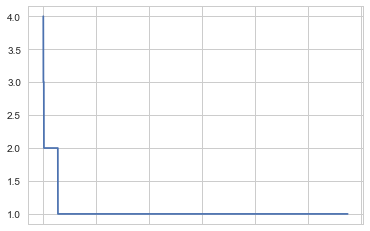

In [313]:
sorted_data2 = sorted_data[sorted_data['F1ROLL']>1]
print(sorted_data2.shape)
sorted_data['F1ROLL'].plot()

In [314]:
modelData_final = modelData_final.rename(columns={"CLAIM_STATUS_TYPE_CD": "Claims"})

In [315]:
modelData_f1dlot = modelData_final.groupby(['F1DLOT']).size().reset_index(name='count')
print (modelData_f1dlot.shape, modelData_f1dlot.head())

(17916, 2)      F1DLOT  count
0     5328A      1
1    601153      6
2    834145      3
3   L128857      2
4   $680760      3


In [316]:
tag = 'F1DLOT'
count, cper = class_info(modelData_final[tag])
tag_unique = set(modelData_final[tag])
uniqueCnt = len(tag_unique)
print(uniqueCnt)

K35101$:       1  =    0.0%
K53885$:       2  =    0.0%
A44107:       1  =    0.0%
CA38446$:       2  =    0.0%
A38502:       1  =    0.0%
A45687$:       1  =    0.0%
P97815:       1  =    0.0%
K50693:       2  =    0.0%
K52652:       1  =    0.0%
P46320:       1  =    0.0%
K45116:       3  =    0.0%
K68189$:       1  =    0.0%
K53932$:       1  =    0.0%
K68624$:       1  =    0.0%
K76479$:       2  =    0.0%
A40522:       1  =    0.0%
K47889:       1  =    0.0%
K57102:       3  =    0.0%
A42194:       1  =    0.0%
KK62916$:       1  =    0.0%
A30668:       1  =    0.0%
A32194:       1  =    0.0%
A53931:       2  =    0.0%
A45128:       2  =    0.0%
A38041:       2  =    0.0%
P37949:       1  =    0.0%
A38267:       2  =    0.0%
A40193:       2  =    0.0%
A40497:       1  =    0.0%
A34399:       1  =    0.0%
A43294:       1  =    0.0%
A45002:       2  =    0.0%
A52737:       4  =    0.0%
P38915:       1  =    0.0%
P38834:       1  =    0.0%
K56599:       1  =    0.0%
K68052:       2  

P51467:       1  =    0.0%
K58263:       1  =    0.0%
K77736:       3  =    0.0%
L135857:       1  =    0.0%
A42057$:       1  =    0.0%
K68050:       1  =    0.0%
P43548:       1  =    0.0%
L129319:       4  =    0.0%
L129500:       5  =    0.0%
K76797:       3  =    0.0%
B997040:       1  =    0.0%
P85023:       1  =    0.0%
A39034$:       2  =    0.0%
P45686:       1  =    0.0%
823507:       4  =    0.0%
833844:       1  =    0.0%
775946:      11  =    0.0%
807434:       4  =    0.0%
L129602:       1  =    0.0%
L126768:       2  =    0.0%
A31625:       2  =    0.0%
772273:       1  =    0.0%
A12767$:       1  =    0.0%
A44206:       1  =    0.0%
A43235:       1  =    0.0%
541664$:       1  =    0.0%
L132859:       1  =    0.0%
L99092:       3  =    0.0%
763161:       1  =    0.0%
A13852$:       1  =    0.0%
866214:       1  =    0.0%
L134115:       2  =    0.0%
L122899:       1  =    0.0%
PP85579:       1  =    0.0%
L127498:       1  =    0.0%
A49431:       1  =    0.0%
866203:     

A50185:       1  =    0.0%
K15229:       1  =    0.0%
P39127:       1  =    0.0%
L130889:       1  =    0.0%
P54284:       2  =    0.0%
A20924:       1  =    0.0%
K70937:       2  =    0.0%
L127531:       1  =    0.0%
P26007:       1  =    0.0%
571554:       1  =    0.0%
650642:       5  =    0.0%
686608:       4  =    0.0%
K47634:       2  =    0.0%
K51568:       2  =    0.0%
832192:       2  =    0.0%
L136036:       1  =    0.0%
L117197:       1  =    0.0%
A22768:       1  =    0.0%
K70025$:       2  =    0.0%
P41673:       1  =    0.0%
A39626$:       1  =    0.0%
P44585:       2  =    0.0%
662918:       1  =    0.0%
P47224:       1  =    0.0%
K67168:       2  =    0.0%
P11823:       1  =    0.0%
K61591:       1  =    0.0%
528926$:       1  =    0.0%
568156 $:       3  =    0.0%
684468:       1  =    0.0%
P42030R:       1  =    0.0%
640723:       1  =    0.0%
P34065:       2  =    0.0%
A40679:       2  =    0.0%
689496:       7  =    0.0%
A38632$:       3  =    0.0%
K41205:       1  

KK54653$:       1  =    0.0%
A45055:       4  =    0.0%
638784:       3  =    0.0%
K69944:       2  =    0.0%
602121:       1  =    0.0%
K54713:       2  =    0.0%
868594:       1  =    0.0%
K54661:       1  =    0.0%
596895:       1  =    0.0%
057505:      11  =    0.0%
A43954:       1  =    0.0%
L126591:       6  =    0.0%
P71237:       1  =    0.0%
673333:       1  =    0.0%
P81796:       2  =    0.0%
700382:       4  =    0.0%
799641:       1  =    0.0%
K77378:       1  =    0.0%
K71710$R:       2  =    0.0%
848539:       1  =    0.0%
A56160:       1  =    0.0%
L118927:       1  =    0.0%
A28424:       1  =    0.0%
P45488:       1  =    0.0%
P64902:       1  =    0.0%
K47298:       1  =    0.0%
749769:       1  =    0.0%
857066:       3  =    0.0%
746090:       2  =    0.0%
P10037R:       3  =    0.0%
A56123:       1  =    0.0%
768747-1:       1  =    0.0%
733549:       2  =    0.0%
PP36391:       1  =    0.0%
P47571:       1  =    0.0%
A18490:       1  =    0.0%
K65632:       1  =

K47901:       1  =    0.0%
K60361:       1  =    0.0%
K63875:       1  =    0.0%
K59238:       1  =    0.0%
P78017:       1  =    0.0%
A54571:       1  =    0.0%
A49211:       1  =    0.0%
P79176:       1  =    0.0%
P41263:       2  =    0.0%
P84481:       1  =    0.0%
L130399:       1  =    0.0%
L131271:       1  =    0.0%
A56040:       1  =    0.0%
A45665:       1  =    0.0%
A48308:       1  =    0.0%
A38037:       1  =    0.0%
A56151:       4  =    0.0%
A45192:       1  =    0.0%
P75188:       1  =    0.0%
613409:       3  =    0.0%
P36096:       1  =    0.0%
PP81666:       1  =    0.0%
393805$:       1  =    0.0%
P37498:       1  =    0.0%
K24247:       1  =    0.0%
XP30478RR:       2  =    0.0%
P63383:       1  =    0.0%
611157$:       2  =    0.0%
653195:       4  =    0.0%
L132625:       2  =    0.0%
XL136381:       1  =    0.0%
829459$:       5  =    0.0%
771098$:      10  =    0.0%
577763:       1  =    0.0%
887821:       1  =    0.0%
 C8303:       1  =    0.0%
A56873:       1

746483$:       3  =    0.0%
P50636:       1  =    0.0%
P49069:       1  =    0.0%
502328$:       4  =    0.0%
P25904:       1  =    0.0%
600439:       6  =    0.0%
P33649:       1  =    0.0%
P41304:       2  =    0.0%
B994034:       1  =    0.0%
P16259:       1  =    0.0%
635700:       5  =    0.0%
701888:       1  =    0.0%
583302:       1  =    0.0%
A54012:       1  =    0.0%
A46587:       2  =    0.0%
A50516:       1  =    0.0%
K44640:       1  =    0.0%
P45388:       2  =    0.0%
P49469:       1  =    0.0%
P53217:       1  =    0.0%
XL135184:       2  =    0.0%
P33599:       2  =    0.0%
P46808:       1  =    0.0%
P31224:       1  =    0.0%
P21024:       1  =    0.0%
P82961:       1  =    0.0%
PP48121:       1  =    0.0%
K37188$:       1  =    0.0%
K54912:       2  =    0.0%
P41665R:       1  =    0.0%
A42262:       2  =    0.0%
P38707:       2  =    0.0%
K47212:       2  =    0.0%
PP37732:       1  =    0.0%
P74962:       1  =    0.0%
KK48811:       2  =    0.0%
671104:       4  =

P71664:       2  =    0.0%
KK72193:       1  =    0.0%
A46370:       2  =    0.0%
KK52887:       1  =    0.0%
P38238:       2  =    0.0%
K45352:       1  =    0.0%
A48916:       1  =    0.0%
P39932:       1  =    0.0%
P27359:       1  =    0.0%
P38620:       1  =    0.0%
L122848:       1  =    0.0%
L128350R:       1  =    0.0%
KK53723R:       1  =    0.0%
L132928:       1  =    0.0%
L103259:       1  =    0.0%
P46519:       1  =    0.0%
L139563:       1  =    0.0%
L119604:       1  =    0.0%
L111856R:       1  =    0.0%
L120770:       1  =    0.0%
P26408:       1  =    0.0%
A48920:       1  =    0.0%
K48937:       1  =    0.0%
K46553:       1  =    0.0%
L129976:       2  =    0.0%
L121130:       2  =    0.0%
P18678:       1  =    0.0%
P30166:       1  =    0.0%
P97316R:       1  =    0.0%
P37677R:       1  =    0.0%
A35884:       1  =    0.0%
P30572:       1  =    0.0%
L134531:       1  =    0.0%
P62499:       1  =    0.0%
L136667:       1  =    0.0%
P513934:       1  =    0.0%
P81318:

$872307:       1  =    0.0%
731824:       1  =    0.0%
869433:       1  =    0.0%
A75462:       1  =    0.0%
501623:       6  =    0.0%
820828AA:       1  =    0.0%
P55084:       2  =    0.0%
K67356:       1  =    0.0%
K77489:       1  =    0.0%
735660:       1  =    0.0%
P54346:       2  =    0.0%
L109555:      17  =    0.1%
704691:       1  =    0.0%
P71861:       1  =    0.0%
626732:       1  =    0.0%
747763A:      32  =    0.1%
A38583:       1  =    0.0%
K39338:       1  =    0.0%
A23337:       6  =    0.0%
P23243:       1  =    0.0%
P38086:       1  =    0.0%
P22279:       1  =    0.0%
KK45224:       1  =    0.0%
P57094:       1  =    0.0%
P50479:       1  =    0.0%
A43760:       1  =    0.0%
P43520:       1  =    0.0%
P80892:       1  =    0.0%
P49671:       1  =    0.0%
PP37855:       1  =    0.0%
A33080:       3  =    0.0%
671625:       6  =    0.0%
800202:       2  =    0.0%
67C0345:       1  =    0.0%
556433:       1  =    0.0%
L131984:       1  =    0.0%
L125883:       1  =

In [317]:
modelData_f1dlot = modelData_final.groupby(['F1DLOT']).size().reset_index(name='count')
print (modelData_f1dlot.shape, modelData_f1dlot.head())

(17916, 2)      F1DLOT  count
0     5328A      1
1    601153      6
2    834145      3
3   L128857      2
4   $680760      3


In [318]:
modelData_f1dlot = modelData_f1dlot.set_index(['F1DLOT'])
print(modelData_f1dlot.head())

          count
F1DLOT         
 5328A        1
 601153       6
 834145       3
 L128857      2
$680760       3


In [319]:
modelData_final = modelData_final.set_index(['F1DLOT'])
modelData_final = pd.concat([modelData_final, modelData_f1dlot], axis=1, join_axes = [modelData_final.index])
print(modelData_final.head(2), modelData_final.shape)

           F1ROLL  CLAIM_NUM   CLAIM Claims  DIM_DIVISION_CUSTOMER_GK  \
F1DLOT                                                                  
K35101$  00156844    7059763  743.85      0                    295061   
K53885$  06157892    7001282  504.10      1                    228961   

          F1GROL  F1GROL_count    F1PROL  INVENTORY_BACKING_CD  \
F1DLOT                                                           
K35101$  4303086             1                               1   
K53885$  4835362             2  05616699                     1   

         INVENTORY_COLOR_CD  ...    INVENTORY_STYLE_CD  claimRatio  \
F1DLOT                       ...                                     
K35101$                   1  ...                     1    0.009489   
K53885$                   2  ...                     2    0.000358   

         dollarClaims  dollarPerClaim  dollarPerSale  dollarSales  numClaims  \
F1DLOT                                                                         
K

In [320]:
modelData_final.reset_index(inplace=True)
modelData_final.rename(columns = {'count': 'F1DLOT_count'}, inplace = True)
print(modelData_final.head(5))

     F1DLOT    F1ROLL  CLAIM_NUM   CLAIM Claims  DIM_DIVISION_CUSTOMER_GK  \
0   K35101$  00156844    7059763  743.85      0                    295061   
1   K53885$  06157892    7001282  504.10      1                    228961   
2   K53885$  06157892    7001282  167.56      1                    228961   
3    A44107  07991120    7060428   54.00      1                    337971   
4  CA38446$  06917531    7028073   99.36      1                    333541   

    F1GROL  F1GROL_count    F1PROL  INVENTORY_BACKING_CD      ...       \
0  4303086             1                               1      ...        
1  4835362             2  05616699                     1      ...        
2  4835362             2  05616699                     1      ...        
3  5048554             1                               1      ...        
4  4882770             1                               1      ...        

   INVENTORY_STYLE_CD  claimRatio  dollarClaims  dollarPerClaim  \
0                   1    

In [351]:
sorted_data = sort_class(modelData_final, 'F1DLOT')
print(sorted_data)

K35101$:       1  =    0.0%
K53885$:       2  =    0.0%
A44107:       1  =    0.0%
CA38446$:       2  =    0.0%
A38502:       1  =    0.0%
A45687$:       1  =    0.0%
P97815:       1  =    0.0%
K50693:       2  =    0.0%
K52652:       1  =    0.0%
P46320:       1  =    0.0%
K45116:       3  =    0.0%
K68189$:       1  =    0.0%
K53932$:       1  =    0.0%
K68624$:       1  =    0.0%
K76479$:       2  =    0.0%
A40522:       1  =    0.0%
K47889:       1  =    0.0%
K57102:       3  =    0.0%
A42194:       1  =    0.0%
KK62916$:       1  =    0.0%
A30668:       1  =    0.0%
A32194:       1  =    0.0%
A53931:       2  =    0.0%
A45128:       2  =    0.0%
A38041:       2  =    0.0%
P37949:       1  =    0.0%
A38267:       2  =    0.0%
A40193:       2  =    0.0%
A40497:       1  =    0.0%
A34399:       1  =    0.0%
A43294:       1  =    0.0%
A45002:       2  =    0.0%
A52737:       4  =    0.0%
P38915:       1  =    0.0%
P38834:       1  =    0.0%
K56599:       1  =    0.0%
K68052:       2  

K79550:       1  =    0.0%
K77456:       2  =    0.0%
K64212:       1  =    0.0%
K75777:       1  =    0.0%
K53115:       2  =    0.0%
K60320:       2  =    0.0%
XK55155:       1  =    0.0%
P57071:       1  =    0.0%
P66516R:       3  =    0.0%
P34001:       1  =    0.0%
L130878:       3  =    0.0%
K66303:       2  =    0.0%
L135269:       1  =    0.0%
P50697:       2  =    0.0%
 C9494:       1  =    0.0%
P21135:       1  =    0.0%
811609:       1  =    0.0%
P77723:       1  =    0.0%
L135099:       1  =    0.0%
P54974:       2  =    0.0%
775935:       1  =    0.0%
715876:       3  =    0.0%
P68403:       2  =    0.0%
P52290:       1  =    0.0%
P58296:       2  =    0.0%
L128887:       1  =    0.0%
C8062SM605:       1  =    0.0%
K62411:       1  =    0.0%
K80184:       1  =    0.0%
K77325:       2  =    0.0%
722693:       1  =    0.0%
K77037:       1  =    0.0%
P77998:       2  =    0.0%
P40948:       1  =    0.0%
0CP44050:       3  =    0.0%
P70471:       1  =    0.0%
K63092:       1 

A53665:       1  =    0.0%
K61017:       1  =    0.0%
K64674:       1  =    0.0%
K73353:       1  =    0.0%
 C8856:       2  =    0.0%
P58770:       1  =    0.0%
P57260:       1  =    0.0%
PP60789:       1  =    0.0%
758627:       1  =    0.0%
848026:       1  =    0.0%
621540:       1  =    0.0%
 P4185:       1  =    0.0%
A55230:       1  =    0.0%
XL130129:       1  =    0.0%
A40531:       1  =    0.0%
P65178:       1  =    0.0%
P34591:       1  =    0.0%
P62696:       1  =    0.0%
L120166:       4  =    0.0%
L130807:       2  =    0.0%
L124661:       1  =    0.0%
A78326:       1  =    0.0%
K62197:       1  =    0.0%
 P9466:       2  =    0.0%
K65774:       1  =    0.0%
645241:       1  =    0.0%
K54031:       1  =    0.0%
569215:       3  =    0.0%
L119824R:       1  =    0.0%
K41711:       1  =    0.0%
P31616:       1  =    0.0%
P65933:       1  =    0.0%
836257:       1  =    0.0%
KK33385:       1  =    0.0%
A27108:       2  =    0.0%
A33830R:       1  =    0.0%
K62171:       1  =

K65000:       1  =    0.0%
P56535R:       1  =    0.0%
666116:       1  =    0.0%
B993002:       1  =    0.0%
517995:       1  =    0.0%
P31346:       2  =    0.0%
L131801:       5  =    0.0%
K53252:       2  =    0.0%
L116531:       1  =    0.0%
P63171:       1  =    0.0%
P16785:       2  =    0.0%
825251:       1  =    0.0%
P71378RR:       1  =    0.0%
A51581:       1  =    0.0%
692938:       2  =    0.0%
P57243:       1  =    0.0%
519519:       2  =    0.0%
L120769:       1  =    0.0%
P651592R:       1  =    0.0%
K54958:       3  =    0.0%
PP75045:       1  =    0.0%
742919:       2  =    0.0%
A43398:       4  =    0.0%
XL130413:       1  =    0.0%
K71279:       3  =    0.0%
CL135903:       2  =    0.0%
P71993:       2  =    0.0%
P59604:       1  =    0.0%
L132619:       7  =    0.0%
 C6852:       3  =    0.0%
L129545:       5  =    0.0%
732501:       1  =    0.0%
P53957:       1  =    0.0%
P66507:       3  =    0.0%
759629:       5  =    0.0%
637775:       1  =    0.0%
P78432:     

P20659:       3  =    0.0%
535303:       9  =    0.0%
 P5549:       1  =    0.0%
P32936:       1  =    0.0%
A56770:       1  =    0.0%
P28544:       3  =    0.0%
L126975:       1  =    0.0%
P32698:       1  =    0.0%
K72269:       1  =    0.0%
K59437:       2  =    0.0%
K81014:       1  =    0.0%
K81825:       1  =    0.0%
852954:       2  =    0.0%
A54680:       1  =    0.0%
A35572:       1  =    0.0%
L129257:       2  =    0.0%
K64436:       1  =    0.0%
A43973$:       5  =    0.0%
K70634:       1  =    0.0%
K48841:       1  =    0.0%
C671438:       1  =    0.0%
C696195:       2  =    0.0%
A55756:       2  =    0.0%
XA54966:       1  =    0.0%
KK57368:       2  =    0.0%
 P5608:       1  =    0.0%
A58275:       1  =    0.0%
A55955:       1  =    0.0%
P79744:       1  =    0.0%
 P6785:       2  =    0.0%
L121968:       1  =    0.0%
L69234:       2  =    0.0%
L132302:       1  =    0.0%
P22307:       1  =    0.0%
AA38570:       1  =    0.0%
L136994:       2  =    0.0%
L124692:       1 

 C7132:       1  =    0.0%
 C7860:       1  =    0.0%
P26501:       1  =    0.0%
P31043:       1  =    0.0%
 C7792:       1  =    0.0%
XP29282:       1  =    0.0%
P26257:       1  =    0.0%
K81403:       1  =    0.0%
P42430:       1  =    0.0%
P52503:       1  =    0.0%
P27165:       1  =    0.0%
L120121:       1  =    0.0%
L110915:       2  =    0.0%
P12590:       1  =    0.0%
A41429:       2  =    0.0%
K28914:       1  =    0.0%
P67189:       1  =    0.0%
P62444:       1  =    0.0%
P57211:       1  =    0.0%
P55941:       1  =    0.0%
P55257:       1  =    0.0%
K58016:       1  =    0.0%
P91689:       1  =    0.0%
811392:       7  =    0.0%
811395:       2  =    0.0%
774470:       2  =    0.0%
797341-148:       1  =    0.0%
412681:       2  =    0.0%
M59831:       2  =    0.0%
456168:      13  =    0.0%
600991:       7  =    0.0%
P80836$:       1  =    0.0%
P84998:       1  =    0.0%
763686:       6  =    0.0%
K11433:       1  =    0.0%
C791783:       1  =    0.0%
657354$:       1  =

 P3918:       1  =    0.0%
K59342:       3  =    0.0%
P41702:       2  =    0.0%
CP52716:       1  =    0.0%
K57016:       4  =    0.0%
P34627:       1  =    0.0%
K56695:       1  =    0.0%
 P6824:       1  =    0.0%
P24857:       1  =    0.0%
P42415:       2  =    0.0%
P63279:       1  =    0.0%
K51566:       1  =    0.0%
P26055:       1  =    0.0%
P49243:       1  =    0.0%
662263:       2  =    0.0%
530497:       2  =    0.0%
K36849:       1  =    0.0%
K51961:       2  =    0.0%
K61118:       1  =    0.0%
P29254:       2  =    0.0%
P43779:       1  =    0.0%
XL136391:       1  =    0.0%
P56467:       1  =    0.0%
K72027$:       1  =    0.0%
K54901:       1  =    0.0%
KK60260:       1  =    0.0%
CP343292:       1  =    0.0%
L129217:       2  =    0.0%
L131994:       2  =    0.0%
P67468R:       1  =    0.0%
L128199:       2  =    0.0%
P45415:       2  =    0.0%
P73966:       1  =    0.0%
P58245:       1  =    0.0%
P69959:       1  =    0.0%
L126259:       1  =    0.0%
L136241:       1

C779823:       1  =    0.0%
K68416:       1  =    0.0%
K71590:       1  =    0.0%
P70104:       1  =    0.0%
P34044:       1  =    0.0%
P63305:       1  =    0.0%
K47594:       1  =    0.0%
816519:       2  =    0.0%
P80952:       1  =    0.0%
P31172:       2  =    0.0%
XK36320:       4  =    0.0%
 K2504:       4  =    0.0%
P50702:       2  =    0.0%
673819:       2  =    0.0%
P75557:       3  =    0.0%
XL135383:       1  =    0.0%
C661010:       1  =    0.0%
XP73273:       1  =    0.0%
A22209:       1  =    0.0%
A44817:       4  =    0.0%
K54566:       1  =    0.0%
583938:       1  =    0.0%
K54010:       1  =    0.0%
K79959:       1  =    0.0%
K39260:       1  =    0.0%
560327$:       2  =    0.0%
K66746:       2  =    0.0%
A37245:       2  =    0.0%
K49040:       1  =    0.0%
K46766:       2  =    0.0%
L83404:       1  =    0.0%
P21214:       1  =    0.0%
663441:       1  =    0.0%
P45008:      10  =    0.0%
P76816:       2  =    0.0%
P76315R:       1  =    0.0%
   713:       1  =  

705738:       6  =    0.0%
L121023:       1  =    0.0%
 C8184:       6  =    0.0%
 C8279:       8  =    0.0%
 C9294:      34  =    0.1%
C9294W:       1  =    0.0%
P63141:       1  =    0.0%
722702:       1  =    0.0%
K52827:       1  =    0.0%
848858:       1  =    0.0%
796192:       2  =    0.0%
725671:       1  =    0.0%
L125590:       1  =    0.0%
A52111:       1  =    0.0%
P34297:       1  =    0.0%
P72725:       1  =    0.0%
K77915:       1  =    0.0%
P46131:       2  =    0.0%
L124933:       1  =    0.0%
P65543:       1  =    0.0%
L115804R:       1  =    0.0%
K36613:       4  =    0.0%
PP45463:       1  =    0.0%
L131133R:       1  =    0.0%
P77121:       1  =    0.0%
L109631:       1  =    0.0%
L128277R:       4  =    0.0%
L109798R:       1  =    0.0%
L124209R:       1  =    0.0%
P56527:       2  =    0.0%
L128891R:       1  =    0.0%
L124967:       1  =    0.0%
A32477:       1  =    0.0%
A31803:       1  =    0.0%
LL136521:       1  =    0.0%
L104903:       1  =    0.0%
L120306

(4849, 2)


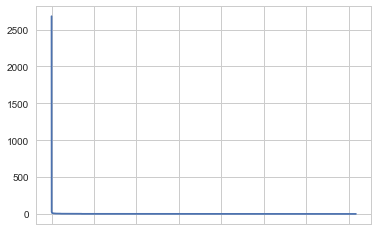

In [352]:
sorted_data2 = sorted_data[sorted_data['F1DLOT']>1]
print(sorted_data2.shape)
sorted_data['F1DLOT'].plot()

In [326]:
# save data into csv file
modelData_final.to_csv(fmodelData)
print(modelData_final.shape, modelData_final.head(2))
class_info(modelData_final.Claims)

(30128, 22)     F1DLOT    F1ROLL  CLAIM_NUM   CLAIM Claims  DIM_DIVISION_CUSTOMER_GK  \
0  K35101$  00156844    7059763  743.85      0                    295061   
1  K53885$  06157892    7001282  504.10      1                    228961   

    F1GROL  F1GROL_count    F1PROL  INVENTORY_BACKING_CD      ...       \
0  4303086             1                               1      ...        
1  4835362             2  05616699                     1      ...        

   INVENTORY_STYLE_CD  claimRatio  dollarClaims  dollarPerClaim  \
0                   1    0.009489        743.85          743.85   
1                   2    0.000358        671.66          671.66   

   dollarPerSale  dollarSales  numClaims  numSales  F1ROLL_count  F1DLOT_count  
0     880.775955     78389.06        1.0      89.0             1             1  
1     652.806290   1875512.47        1.0    2873.0             2             2  

[2 rows x 22 columns]
     0:    8647  =   28.7%
     1:   21481  =   71.3%


(Counter({'0': 8647, '1': 21481}), [0.28700876261285185, 0.7129912373871482])

In [327]:
qcount, qper = class_info(modelData_final.Claims)
print(qcount, qper)
_plot_classpie(qcount)

     0:    8647  =   28.7%
     1:   21481  =   71.3%
Counter({'1': 21481, '0': 8647}) [0.28700876261285185, 0.7129912373871482]


In [329]:
print(modelData_final.columns.values)

['F1DLOT' 'F1ROLL' 'CLAIM_NUM' 'CLAIM' 'Claims' 'DIM_DIVISION_CUSTOMER_GK'
 'F1GROL' 'F1GROL_count' 'F1PROL' 'INVENTORY_BACKING_CD'
 'INVENTORY_COLOR_CD' 'INVENTORY_SIZE_CD' 'INVENTORY_STYLE_CD' 'claimRatio'
 'dollarClaims' 'dollarPerClaim' 'dollarPerSale' 'dollarSales' 'numClaims'
 'numSales' 'F1ROLL_count' 'F1DLOT_count']


# Check final model data

In [328]:
n, bins, patches = plt.hist(modelData_final['dollarPerClaim'], bins='auto', facecolor='green', alpha=0.75)

In [343]:
modelData_new = modelData_final[modelData_final["F1DLOT_count"] < 200]
print(modelData_new.shape)

(27448, 22)


In [346]:
sns.lmplot(x="F1GROL_count", y="claimRatio", data=modelData_new, hue="Claims",  markers=["o", "x"],
           palette="Set1", fit_reg=False, size = 8);

# Model Prediction Data Processing

In [112]:
#test
test_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/SmartClaim/Data/claim_input.csv'
testData = pd.read_csv(test_dataPath, encoding='latin1')  # Read the claims data
print(testData.head(2), testData.shape)

   Unnamed: 0  CLAIM_NUM INVENTORY_STYLE_CD INVENTORY_SIZE_CD  \
0           0    7128208              27949              1200   
1           1    7128013              27949              1200   

  INVENTORY_BACKING_CD INVENTORY_COLOR_CD  DIM_DIVISION_CUSTOMER_GK    CLAIM  \
0                    A                728                    299832   635.70   
1                    A              81336                    299832  1501.67   

   TOTAL_CLAIM  TOTAL_CLAIM_CNT  TRX_CNT  NET_SALES  
0       666.08                3       58  952219.01  
1      1574.24                4       26  221429.41   (326, 12)


In [117]:
# testing new data for encoder
INPUT_TAGS = ['numClaims',
              'numSales',
              'dollarPerClaim',
              'dollarPerSale',
              'claimRatio',
              'INVENTORY_STYLE_CD',
              'INVENTORY_SIZE_CD',
              'INVENTORY_BACKING_CD',
              'INVENTORY_COLOR_CD'
              ]

testData.rename(columns={'TOTAL_CLAIM_CNT': 'numClaims', 'TRX_CNT': 'numSales', 
                         'TOTAL_CLAIM':'dollarClaims', 'NET_SALES':'dollarSales'}, inplace=True)
tagList = ['numClaims', 'numSales','dollarClaims', 'dollarSales']
        
for item in tagList:
    testData = _convert_float(testData, item)

modelData = testData
modelData['dollarPerClaim'] = modelData['dollarClaims']/modelData['numClaims']
modelData['dollarPerSale'] = modelData['dollarSales']/modelData['numSales']
modelData['claimRatio'] = modelData['dollarClaims']/modelData['dollarSales']
        
print(modelData.head(4), modelData.shape)
        
#import input tags
#modelData_inf = _replace_inf(modelData)
X = modelData[INPUT_TAGS]

   Unnamed: 0  CLAIM_NUM INVENTORY_STYLE_CD INVENTORY_SIZE_CD  \
0           0    7128208              27949              1200   
1           1    7128013              27949              1200   
2           2    7128223              27931              1200   
3           3    7132728              32519              0500   

  INVENTORY_BACKING_CD INVENTORY_COLOR_CD  DIM_DIVISION_CUSTOMER_GK    CLAIM  \
0                    A                728                    299832   635.70   
1                    A              81336                    299832  1501.67   
2                    A                740                    299832   346.01   
3                   EW                 96                    251961    54.97   

   dollarClaims  numClaims  numSales  dollarSales  dollarPerClaim  \
0        666.08        3.0      58.0    952219.01      222.026667   
1       1574.24        4.0      26.0    221429.41      393.560000   
2        226.38        1.0      30.0    305721.91      226.380000 

In [121]:
#encodeing
tag_style = 'INVENTORY_STYLE_CD'
X, numb_style = _encode_label_(X, tag_style, encoder_style_)
        
tag_back = 'INVENTORY_BACKING_CD'
X, numb_back = _encode_label_(X, tag_back,encoder_back_)
        
tag_size = 'INVENTORY_SIZE_CD'
X, numb_size = _encode_label_(X, tag_size, encoder_size_)
        
tag_color = 'INVENTORY_COLOR_CD'
X, numb_color = _encode_label_(X, tag_color, encoder_color_)

C:\anaconda35\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [122]:
print(X.head(400))

     numClaims  numSales  dollarPerClaim  dollarPerSale  claimRatio  \
0          3.0      58.0      222.026667   16417.569138    0.000700   
1          4.0      26.0      393.560000    8516.515769    0.007109   
2          1.0      30.0      226.380000   10190.730333    0.000740   
3          7.0      25.0       79.394286    5011.930000    0.004435   
4          2.0      89.0      776.315000    4927.125056    0.003541   
5          1.0      13.0     3249.490000    2275.264615    0.109860   
6          1.0      18.0     6456.020000    8576.111111    0.041822   
7          2.0     156.0      202.710000    1760.732436    0.001476   
8          2.0     174.0      583.500000    1948.712471    0.003442   
9          4.0      91.0      725.267500    4622.957802    0.006896   
10         1.0      76.0      157.400000     710.905263    0.002913   
11         4.0     212.0      681.882500    2178.914481    0.005905   
12         4.0     100.0      370.420000    1023.925300    0.014471   
13    

# Test get dummy function

In [91]:
tag = ['INVENTORY_STYLE_CD','INVENTORY_BACKING_CD', 'INVENTORY_SIZE_CD', 'INVENTORY_COLOR_CD']
dummy_res = _convert_dummy(Claims_AMT, tag)
dummy_res.head(10)
dummy_res.shape

(62658, 4458)

In [93]:
df_dummy = pd.get_dummies(data=Claims_AMT, columns=tag)
print(df_dummy.head(2))

   index  Unnamed: 0  PRIMARY_CUSTOMER_GK  DIM_CLAIM_TYPE_PK  \
0      0           0               322634                 21   
1      1           1               258724                 21   

   DIM_CLAIM_STATUS_PK  DIM_CLAIM_REASON_PK  DIM_FINISHED_PRODUCT_SELL_GK  \
0                   37                  263                       3835141   
1                   37                  277                       3835141   

  SELLING_STYLE_CD SELLING_STYLE_DESC SELLING_STYLE_SHORT_DESC  \
0            43518       FASHION ICON                 FASHIONI   
1            43518       FASHION ICON                 FASHIONI   

            ...            INVENTORY_COLOR_CD_2134 INVENTORY_COLOR_CD_2135  \
0           ...                                  0                       0   
1           ...                                  0                       0   

  INVENTORY_COLOR_CD_2136 INVENTORY_COLOR_CD_2137 INVENTORY_COLOR_CD_2138  \
0                       0                       0               

In [73]:
tag = 'INVENTORY_BACKING_CD'
Claims_AMT, encoder_back = _encode_label(Claims_AMT, tag)
Claims_AMT[tag].head(100)

C:\anaconda35\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0      32
1      32
2      32
3      32
4      32
5      32
6      32
7      32
8      32
9      32
10     32
12     32
13     32
14     32
16     32
17     32
18     32
19     32
20     32
21     32
23     32
24     32
25     32
26     32
27     32
28     32
29     32
30     32
31     32
32     32
       ..
78      4
79      4
81      4
82      4
83      4
84      4
85      4
87      4
88      4
89      4
90      4
91      4
92      4
93      4
94      4
95      4
96      4
97      4
98      4
99      4
100     4
101     4
102     4
103     4
104     4
105     4
106     4
107     4
108     4
109     4
Name: INVENTORY_BACKING_CD, Length: 100, dtype: int64

In [74]:
tag = 'INVENTORY_SIZE_CD'
Claims_AMT, encoder_size = _encode_label(Claims_AMT, tag)
Claims_AMT[tag].head(100)

C:\anaconda35\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0      34
1      34
2      34
3      34
4      34
5      34
6      34
7      34
8      34
9      34
10     34
12     34
13     34
14     34
16     34
17     34
18     34
19     34
20     34
21     34
23     34
24     34
25     34
26     34
27     34
28     34
29     34
30     34
31     34
32     34
       ..
78     34
79     34
81     34
82     34
83     34
84     34
85     34
87     34
88     34
89     34
90     34
91     34
92     34
93     34
94     34
95     34
96     34
97     34
98     34
99     34
100    34
101    34
102    34
103    34
104    34
105    34
106    34
107    34
108    34
109    34
Name: INVENTORY_SIZE_CD, Length: 100, dtype: int64

In [75]:
tag = 'INVENTORY_COLOR_CD'
Claims_AMT, encoder_color = _encode_label(Claims_AMT, tag)
Claims_AMT[tag].head(100)

C:\anaconda35\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0      1195
1      1195
2      1195
3      1195
4      1195
5      1195
6      1195
7      1195
8      1195
9      1195
10     1196
12     1196
13     1196
14     1196
16     1196
17     1242
18     1242
19     1242
20     1242
21     1242
23     1245
24     1245
25     1245
26     1411
27     1417
28     1417
29     1417
30     1417
31     1417
32     1417
       ... 
78     1430
79     1457
81     1457
82     1457
83     1457
84     1457
85     1457
87     1459
88     1480
89     1480
90     1480
91     1480
92     1480
93     1480
94     1550
95     1550
96     1592
97     1592
98     1592
99     1592
100    1592
101    1121
102    1121
103    1221
104    1221
105    1237
106    1237
107    1237
108    1244
109    1249
Name: INVENTORY_COLOR_CD, Length: 100, dtype: int64

In [ ]:
Claims_Class = pd.DataFrame({'numClaims': Claims_AMT.groupby(["PRIMARY_CUSTOMER_GK", "CLAIM_STATUS_TYPE_CD", 
                                                              "INVENTORY_STYLE_CD", "INVENTORY_SIZE_CD", "INVENTORY_BACKING_CD",
                                                              "INVENTORY_COLOR_CD"]).size()}).reset_index()
print(Claims_Class.shape, Claims_Class.head(20))

In [ ]:
Claims_Dollar = pd.DataFrame({'dollarClaims': Claims_AMT.groupby(["PRIMARY_CUSTOMER_GK", "CLAIM_STATUS_TYPE_CD", 
                                                              "INVENTORY_STYLE_CD", "INVENTORY_SIZE_CD", "INVENTORY_BACKING_CD",
                                                              "INVENTORY_COLOR_CD"])['TOTAL_CLAIMS_DOLLAR_AMT'].sum()}).reset_index()
Claims_Dollar = Claims_Dollar.drop("CLAIM_STATUS_TYPE_CD", axis=1)
print(Claims_Dollar.shape, Claims_Dollar.head(20))

In [ ]:
dropList = ['INVENTORY_STYLE_CD','INVENTORY_SIZE_CD','INVENTORY_BACKING_CD', 'INVENTORY_COLOR_CD']
Claims_Classb = Claims_Class.drop(dropList, axis = 1)
#Claims_Classb.reset_index(inplace=True)
print(Claims_Classb.head(2))
num_Dollar = sum(Claims_Class.numClaims)
print(num_Dollar)

In [ ]:
Claims_Dollar = Claims_Dollar.set_index('PRIMARY_CUSTOMER_GK')
Claims_Class = Claims_Classb.set_index('PRIMARY_CUSTOMER_GK')
Claims_Con = pd.concat([Claims_Class, Claims_Dollar], axis=1)
print(Claims_Con.head(2), Claims_Con.shape)

In [ ]:
customer_unique = set(customerSale.index)
uniqueCnt = len(customer_unique)
print(uniqueCnt) 

In [ ]:
claims_unique = set(Claims_Con.index)
uniqueCnt = len(claims_unique)
print(uniqueCnt) 

# Combine Claims and Sales data

In [ ]:
#Claims_Customer = Claims_Type.join(ClaimCustomer, rsuffix = '_customer')
Claims_Customer = pd.concat([Claims_Con, customerSale, customerName], axis=1, join_axes = [Claims_Con.index])
Claims_Customer = Claims_Customer.rename(columns={"CLAIM_STATUS_TYPE_CD": "Claims"})
print(Claims_Customer.shape, Claims_Customer.head(5))

In [ ]:
tagList = list(Claims_Customer.head(1).columns.values)
print(tagList, len(tagList))

In [ ]:
tagList1 = [x for x in tagList if "_reason" not in x]
tagList2 = [x for x in tagList1 if "_status" not in x]
tagList3 = [x for x in tagList2 if "_type" not in x]
tagList = [x for x in tagList3 if "_customer" not in x]
print(tagList, len(tagList))

In [ ]:
# save data into csv file
ClaimData = Claims_Customer[tagList]
ClaimData.to_csv(fprocData)
print(ClaimData.shape)

# Claim Data Processing
Building the recommendation/scoring model from Customer angle. Factors used in the modeling:
- Customer Name
- SLS = Sales
- TOTAL_CLAIMS_DOLLAR_AMT = $Claims

Derivated variables:
 - Total claims each customer in past year = #claim
 - Dollars each claim each customer = $/claim
 
 - Total sales each customer = SLS
 - Dollars per sale each customer = $/sale
 - Claim to sale ratio = claim/SLS
 
Product variables:
 - Product size
 - Product style
 - Product Color
 - Product Backing

In [ ]:
# read consildated claim data
ClaimData = pd.read_csv(fprocData, encoding='latin1') # Read the data
print(ClaimData.columns)

In [ ]:
remove_list = ['FISCAL_YR_NUM',
       'FISCAL_MONTH_NUM', 'SOLD_TO_CUSTOMER_PK', 'CUSTOMER_NUM',
       'CUSTOMER_SUFFIX_NUM', 'SLS']
for item in remove_list:
    ClaimData = ClaimData.drop(item, axis=1)
    
print(ClaimData.shape, ClaimData.head(2))

In [ ]:
# filter data to have SLS > 10
customerData_SLS = ClaimData[ClaimData["dollarSales"]>100]
sns.distplot(customerData_SLS["dollarSales"])
print(customerData_SLS.shape)

In [ ]:
sns.distplot(customerData_SLS["dollarClaims"])

In [ ]:
# filter data to have TOTAL_CLAIMS_DOLLAR_AMT > 1
customerData_AMT = customerData_SLS[ClaimData['dollarClaims']>0]
sns.distplot(customerData_AMT['dollarClaims'])
print(customerData_AMT.shape)

In [ ]:
def _plot_scatter(data, xTag, yTag):
    # Set style of scatterplot
    #sns.set_context("notebook", font_scale=1.1)
    #sns.set_style("ticks")
    from itertools import cycle
    color_gen = cycle(('blue', 'lightgreen', 'red', 'purple', 'gray', 'cyan'))

    # Create scatterplot of dataframe
    fig = plt.figure(figsize=(11,4)) 
    plt.scatter(data[xTag], # Horizontal axis
               data[yTag], # Vertical axis
               c = next(color_gen))

    # Set title
    plt.title(yTag + ' vs ' + xTag)

    # Set x-axis label
    plt.xlabel(xTag)

    # Set y-axis label
    plt.ylabel(yTag)
    plt.show()

xTag = 'dollarClaims'
yTag = 'dollarSales'
_plot_scatter(ClaimData, xTag, yTag)

In [ ]:
_plot_scatter(customerData_SLS, xTag, yTag)

In [ ]:
_plot_scatter(customerData_AMT, xTag, yTag)

In [ ]:
index_nan = ClaimData['dollarClaims'].index[ClaimData['dollarClaims']<100]
print(index_nan.shape)

In [ ]:
index_nan2 = customerData_SLS['dollarClaims'].index[customerData_SLS['dollarClaims']<0]
print(index_nan2.shape)

In [ ]:
customerData = customerData_AMT.groupby(['CUSTOMER_NAME', 'dollarClaims']).sum()
print(customerData.shape)

In [ ]:
ClaimData = customerData_AMT
#create a pivot table to reshape the data, using sum or count function
claimDollar = ClaimData.pivot_table(index='CUSTOMER_NAME', values='dollarClaims', aggfunc=sum)
print(claimDollar.head(2), claimDollar.shape)

In [ ]:
claimDollar_na = claimDollar.dropna(axis=0, how = 'any')
print(claimDollar_na.shape)

In [ ]:
#create a pivot table to reshape the data, using sum or count function
"""
saleNumber = ClaimData.pivot_table(index='CUSTOMER_NAME', values='SLS', aggfunc=len)
saleNumber = saleNumber.rename(columns = {'SLS':'NumberSales'})
saleDollar = ClaimData.pivot_table(index='CUSTOMER_NAME', values='SLS', aggfunc=sum)
print(saleDollar.head(2), saleDollar.shape)
"""

In [ ]:
#saleDollar_na = saleDollar.dropna(axis = 0, how = 'any')
#print(saleDollar_na.shape)

In [ ]:
#saleData = pd.concat([saleDollar_na, saleNumber], axis=1, join_axes=[saleDollar_na.index])
#saleData['DollarPerSale'] = saleData['SLS']/saleData['NumberSales']
#print(saleData.shape, saleData.head(2))

In [ ]:
#customerData = pd.concat([saleData, claimDollar_na], axis=1, join_axes=[saleData.index])
#customerData['ClaimRatio'] = customerData['TOTAL_CLAIMS_DOLLAR_AMT']/customerData['SLS']
#print(customerData.shape, customerData.head(2))

In [ ]:
#create a pivot table to reshape the data, using sum or count function
#claimCnt = ClaimData.pivot_table(index='CUSTOMER_NAME', values='TOTAL_CLAIMS_DOLLAR_AMT', aggfunc=len)
#claimCnt = claimCnt.rename(columns = {'TOTAL_CLAIMS_DOLLAR_AMT':'Total_Claims'})
#print(claimCnt.head(2), claimCnt.shape)

In [ ]:
# join count claim
#modelData = pd.concat([customerData, claimCnt], axis=1, join_axes=[customerData.index])
modelData = ClaimData
modelData['dollarPerClaim'] = modelData['dollarClaims']/modelData['numClaims']
modelData['dollarPerSale'] = modelData['dollarSales']/modelData['numSales']
modelData['claimRatio'] = modelData['dollarClaims']/modelData['dollarSales']
print(modelData.shape, modelData.head(2))

In [ ]:
modelData.reset_index(inplace=False)
print(modelData.head(20), modelData.shape)

In [ ]:
xTag = 'numSales'
yTag = 'numClaims'
_plot_scatter(modelData, xTag, yTag)

In [ ]:
 ax = sns.regplot(x=xTag, y=yTag, data=modelData)

# Visualization of modeling data

In [ ]:
print(modelData.shape, modelData.head(2))

In [ ]:
#sns.lmplot(x="SLS", y="ClaimRatio", data=modelData, hue="ClaimRatio", fit_reg=False, size = 8);
#series plot over three sigma

yName = "dollarClaims"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

In [ ]:
yName = "claimRatio"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

In [ ]:
# ClaimAMT = 0
CR0 = modelData[modelData["claimRatio"]==0]
print(CR0.shape)

In [ ]:
LargeCR = modelData[modelData["claimRatio"] > 1]
print(LargeCR.shape)

In [ ]:
modelData_tmp = modelData[modelData['claimRatio'] < 1]
data = modelData_tmp['claimRatio']
sns.distplot(data, bins=30)
plt.show()

In [ ]:
LargeDPS= modelData[modelData["dollarPerSale"] > 1000]
print(LargeDPS.shape)

In [ ]:
tag = 'dollarPerSale'
modelData_tmp = modelData[modelData[tag] < 10000]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

In [ ]:
tag = 'numSales'
LargeS= modelData[modelData[tag] > 10]
print(LargeS.shape)

modelData_tmp = modelData[modelData[tag] < 40]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

In [ ]:
LargeDPC= modelData[modelData["dollarPerClaim"] > 1000]
print(LargeDPC.shape)

In [ ]:
tag = 'dollarPerClaim'
modelData_tmp = modelData[modelData[tag] < 1000]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

In [ ]:
tag = 'dollarClaims'
LargeC= modelData[modelData[tag] > 10]
print(LargeC.shape)

modelData_tmp = modelData[modelData[tag] < 40]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

In [ ]:
yName = "dollarSales"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

In [ ]:
yName = "dollarPerClaim"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

In [ ]:
n, bins, patches = plt.hist(xd, bins='auto', facecolor='green', alpha=0.75)
print(xd.describe())

In [ ]:
# box plot
plt.hist(np.array(modelData['claimRatio']), color=['r'], alpha=0.5, label='claimRatio')
plt.legend(loc='upper right')
plt.show()

In [ ]:
_plot_boxplot(np.array(modelData['claimRatio']))

In [ ]:
#series plot over three sigma
yName = "claimRatio"
ifactor = 3
xd = modelData[yName]
_plot_QQ(xd) 

In [ ]:
import pandas as pd
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 20)
#pd.set_option('display.width', 1000)

In [ ]:
# save data into csv file
modelData.to_csv(fmodelData)
print(modelData.shape, modelData.head(2))
class_info(modelData.Claims)

In [ ]:
modelData.drop(['Unnamed: 0', 'index'], inplace=True, axis = 1)
print(modelData.head(5))

In [ ]:
modelData_gk = modelData.set_index('PRIMARY_CUSTOMER_GK')
print(modelData_gk.head(5))

# Preprocess inputs to model Claim Scoring

Possible Inputs:
- ClaimRatio
- DollarPerClaim ($/claim)

- DollarPerSale ($/sale)
- #Sales
- #Claims

In [ ]:
# read consildated model data
modelData = pd.read_csv(fmodelData, encoding='latin1') # Read the data
print(modelData.columns, modelData.head(5))

In [ ]:
# Normalize data
    # manually selected tags -- no normalized or PCA
def _read_inputTags():
    inputTags = ['numClaims',
                 'numSales',
                 'dollarPerClaim',
                 'dollarPerSale',
                 'claimRatio',
                 'INVENTORY_STYLE_CD',
                 'INVENTORY_SIZE_CD',
                 'INVENTORY_BACKING_CD',
                 'INVENTORY_COLOR_CD'
                ]
    return inputTags

inputTags = _read_inputTags()
yTags = 'Claims'

In [ ]:
customerID = modelData['CUSTOMER_NAME']
X = modelData[inputTags]
y = modelData[yTags]

print(X.head(2), X.shape)

In [ ]:
csClaim, pclaim = class_info(y)

In [ ]:
objects = csClaim.keys()
y_pos = np.arange(len(objects))
x_claims = list(csClaim.values())[::-1] 
_plot_classbar(x_claims, y_pos)

In [ ]:
# split data
ts = 0.3
xTrain, xTest, yTrain, yTest = train_test_split(X, y, stratify=y, test_size=ts, random_state=531)  

In [ ]:
# normalize data
xvalue = xTrain.values 
normX_scaler = preprocessing.StandardScaler().fit(xvalue) 
xScaled = normX_scaler.transform(xvalue)   
xScaled_test = normX_scaler.transform(xTest.values) 
xnTrain = pd.DataFrame(xScaled)
xnTest = pd.DataFrame(xScaled_test)

In [ ]:
xnTrain.index = xTrain.index
xnTrain.columns = xTrain.columns
xnTest.index = xTest.index
xnTest.columns = xTest.columns

In [ ]:
class_info(yTrain)
class_info(yTest)

In [ ]:
#split the training data into modeling set and validation set
nxModel, nxValid, yModel, yValid = train_test_split(xnTrain, yTrain, stratify=yTrain, test_size=ts, random_state=531)
class_info(yModel)
class_info(yValid)

# Modeling using Different Methods

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets
from sklearn.utils.validation import column_or_1d
from sklearn.metrics import accuracy_score

In [ ]:
# <codecell>

# let's switch to 2-dimensional curves; specifically, the ROC and precision-recall curves.
# Define two functions to plot ROC and Precision-Recall curves.

def plot_ROC_curve(classifier, X, y, pos_label=1, n_folds=5):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure()
    aucs = []
    all_tpr = []
    for i, (train, test) in enumerate(StratifiedKFold(y, n_folds=n_folds)):
        probas_ = classifier.fit(X.iloc[train,:], y[train]).predict_proba(X.iloc[test,:])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        all_tpr.append(mean_tpr)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random', alpha=0.8)
    
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), 
         lw=2, alpha=0.8)
    
    std_tpr = np.std(all_tpr, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha=0.2,
                     label = r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return classifier
  

In [ ]:
xm = nxModel.iloc[:, 3:5]
#xm = pd.DataFrame(xm)
print(xm.head(2))
n_features = X.shape[1]

C = 1.0
kernel = 1.0 * RBF([1.0, 1.0])  # for GPC

In [ ]:
# Create different classifiers. The logistic regression cannot do
# multiclass out of the box.
classifiers = {'L1 logistic': LogisticRegression(C=C, penalty='l1'),
               'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2'),
               'RBF SVC': SVC(kernel='rbf', C=C, class_weight='balanced',probability=True,
                                 random_state=0),
               'Linear SVC': SVC(kernel='linear', C=C, class_weight='balanced',probability=True,
                                 random_state=0),
               'L2 logistic (Multinomial)': LogisticRegression(
                C=C, solver='lbfgs', multi_class='multinomial')
               #'GPC': GaussianProcessClassifier(kernel)
               }

n_classifiers = len(classifiers)

In [ ]:
plt.figure(figsize=(3 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=.2, top=.95)

xx = np.linspace(3, 9, 100)
yy = np.linspace(1, 5, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(xm, yModel)

    y_pred = classifier.predict(xm)
    classif_rate = np.mean(y_pred.ravel() == yModel.ravel()) * 100
    print("classif_rate for %s : %f " % (name, classif_rate))

    # View probabilities=
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(3, 9, 1, 5), origin='lower')
        plt.xticks(())
        plt.yticks(())
        idx = (y_pred == k)
        if idx.any():
            plt.scatter(xm.iloc[idx,0], xm.iloc[idx,1], marker='o', c='k')

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

In [ ]:
def _verify_claim(classifier, xValid, yValid):
    
    y_pred = classifier.predict(xValid)
    classif_rate = np.mean(y_pred.ravel() == yValid.ravel()) * 100
    print("classif_rate for %s : %f \n" % (name, classif_rate))

    # Output probabilities
    valFull = np.c_[xValid, yValid]
    probas = classifier.predict_proba(xValid)
    
    test_results = [Declined', 'Paid']   
    print ("\nModel Report")
    print(classification_report(yValid, y_pred, target_names= test_results))
    print("Predicted Declined Claims = %s" %sum(column_or_1d(y_pred)))
    print ("Accuracy : %.4g" % accuracy_score(yValid.values, y_pred))
    
    # output results
    proba = pd.DataFrame(data=probas[:,0], index = yValid.index, columns = ['Score'])
    yPred = pd.DataFrame(data=y_pred, index = yValid.index, columns = ['Pred'])
    res_pred = pd.concat([yValid, yPred, proba], axis=1)
    return res_pred    

In [ ]:
for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(nxModel, yModel)
    res_pred = _verify_claim(classifier, nxValid, yValid)

In [ ]:
print(res_pred.head(20), res_pred.shape)

# Plot claim scoring data

In [ ]:
# read consildated claim data
fscoreData = 'C:/Users/E154709/Desktop/Mohawk/Claims/eclf_output.csv'
claimScore = pd.read_csv(fscoreData, encoding='latin1') # Read the data
print(claimScore.head(5), claimScore.shape)

In [ ]:
claimScore = claimScore.rename(columns={"Unnamed: 0": "Customer_GK", "Index": "Type"})
sortScore = claimScore.sort_values(by='Score')
sortScore.reset_index(inplace = True)
sns.lmplot(x="Item", y="Score", data=sortScore, hue="Pred", fit_reg=False, size = 8);
sns.lmplot(x="Item", y="Score", data=sortScore, hue="Claims", fit_reg=False, size = 8);

In [ ]:
#sortScore = sortScore.drop('level_0', axis = 1)
print(sortScore.head(5), sortScore.shape)

In [ ]:
sns.lmplot(x = "dollarPerSale", y="Score", data=sortScore, hue="Claims", fit_reg=False, size = 8);

In [ ]:
sns.set(style="whitegrid", palette="pastel", color_codes=False)

In [ ]:
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x="Claims", y="Score", data=sortScore, hue="Pred", split=True,
               inner="quart", palette={1: 'b', 0: 'r'})
sns.despine(left=True)

In [ ]:
# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x="Claims", y="Score", data=sortScore, hue="Pred", palette="PRGn")
sns.despine(offset=10, trim=True)